<a href="https://colab.research.google.com/github/bintangfikrif/Unnamed-Final_Project/blob/main/notebooks/main.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Install & Import General Library**

In [1]:
pip install linearmodels

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 37.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 115.7/115.7 kB 8.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.9/43.9 kB 3.1 MB/s eta 0:00:00


In [ ]:
pip install pmdarima

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 16.9 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, mean_absolute_percentage_error
from scipy import stats
from statsmodels.tools.sm_exceptions import ConvergenceWarning, HessianInversionWarning, ValueWarning
from statsmodels.tsa.arima_model import ARIMAResults
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import warnings
warnings.filterwarnings('ignore')

plt.style.use('default')
plt.rcParams['figure.figsize'] = (12, 8)
sns.set_palette("viridis")

# **Load Dataset**

In [3]:
# --- 1. Load Datasets ---
try:
    forest_df = pd.read_csv('/content/spatial-metrics-indonesia-remaining_forest_province.csv')
    deforest_df = pd.read_csv('/content/spatial-metrics-indonesia-territorial_deforestation_province.csv')

    print("Natural Forest Area by Province")
    display(forest_df.head())

    print("\nDeforestation Area by Province")
    display(deforest_df.head())

except FileNotFoundError:
    print("Error: File not found. Please ensure the file forest and deforest exists in the current directory.")
    forest_df = None
    deforest_df = None
except Exception as e:
    print(f"An unexpected error occurred: {e}")
    forest_df = None
    deforest_df = None

Natural Forest Area by Province


,year,country,country_iso2,region,region_trase_id,parent_region,parent_region_trase_id,natural_forest_area_hectares
0,2001,INDONESIA,ID,ACEH,ID-11,SUMATERA,ID-SM,3.624507e+06
1,2001,INDONESIA,ID,BALI,ID-51,NUSA TENGGARA,ID-NU,6.375161e+04
2,2001,INDONESIA,ID,BANTEN,ID-36,JAWA,ID-JW,6.599245e+04
3,2001,INDONESIA,ID,BENGKULU,ID-17,SUMATERA,ID-SM,2.682920e+05
4,2001,INDONESIA,ID,D I YOGYAKARTA,ID-34,JAWA,ID-JW,1.080000e+01



Deforestation Area by Province


,year,country,country_iso2,region,region_trase_id,parent_region,parent_region_trase_id,deforestation_hectares
0,2001,INDONESIA,ID,ACEH,ID-11,SUMATERA,ID-SM,4097.692235
1,2001,INDONESIA,ID,BALI,ID-51,NUSA TENGGARA,ID-NU,5.130000
2,2001,INDONESIA,ID,BANTEN,ID-36,JAWA,ID-JW,1.260000
3,2001,INDONESIA,ID,BENGKULU,ID-17,SUMATERA,ID-SM,1906.404000
4,2001,INDONESIA,ID,D I YOGYAKARTA,ID-34,JAWA,ID-JW,0.000000


# **Exploratory Data Analysis (EDA)**



 Analisis Data Eksploratif: Luas Hutan Alami per Provinsi 
------------------------------------------------------------

 Informasi Dataset Luas Hutan Alami:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 8 columns):
 #   Column                        Non-Null Count  Dtype  
---  ------                        --------------  -----  
 0   year                          748 non-null    int64  
 1   country                       748 non-null    object 
 2   country_iso2                  748 non-null    object 
 3   region                        748 non-null    object 
 4   region_trase_id               748 non-null    object 
 5   parent_region                 748 non-null    object 
 6   parent_region_trase_id        748 non-null    object 
 7   natural_forest_area_hectares  748 non-null    float64
dtypes: float64(1), int64(1), object(6)
memory usage: 46.9+ KB

 Statistik Deskriptif Luas Hutan Alami:


,year,country,country_iso2,region,region_trase_id,parent_region,parent_region_trase_id,natural_forest_area_hectares
count,748.000000,748,748,748,748,748,748,7.480000e+02
unique,NaN,1,1,34,34,7,7,NaN
top,NaN,INDONESIA,ID,ACEH,ID-11,SUMATERA,ID-SM,NaN
freq,NaN,748,748,22,22,220,220,NaN
mean,2011.500000,NaN,NaN,NaN,NaN,NaN,NaN,2.705803e+06
std,6.348534,NaN,NaN,NaN,NaN,NaN,NaN,4.683202e+06
min,2001.000000,NaN,NaN,NaN,NaN,NaN,NaN,9.720000e+00
25%,2006.000000,NaN,NaN,NaN,NaN,NaN,NaN,2.548762e+05
50%,2011.500000,NaN,NaN,NaN,NaN,NaN,NaN,8.713053e+05
75%,2017.000000,NaN,NaN,NaN,NaN,NaN,NaN,3.074278e+06



 Pengecekan Nilai Hilang Luas Hutan Alami:


,0
year,0
country,0
country_iso2,0
region,0
region_trase_id,0
parent_region,0
parent_region_trase_id,0
natural_forest_area_hectares,0


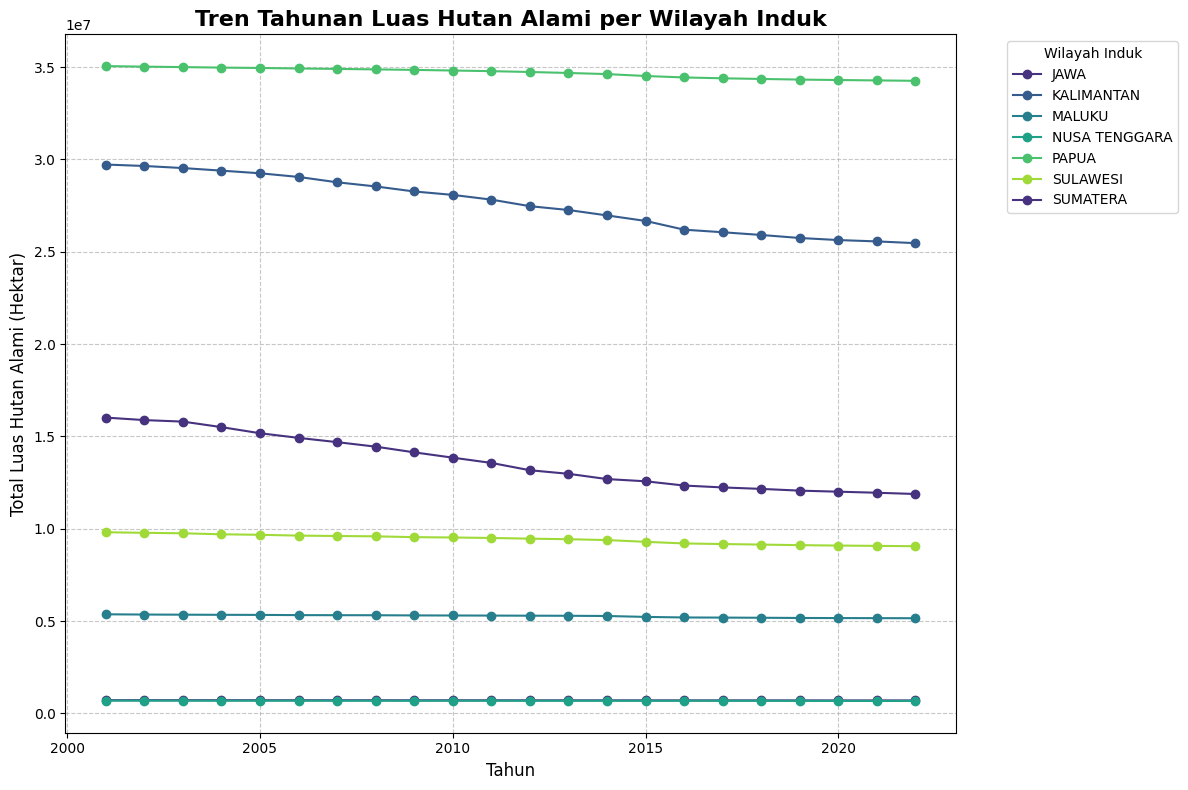

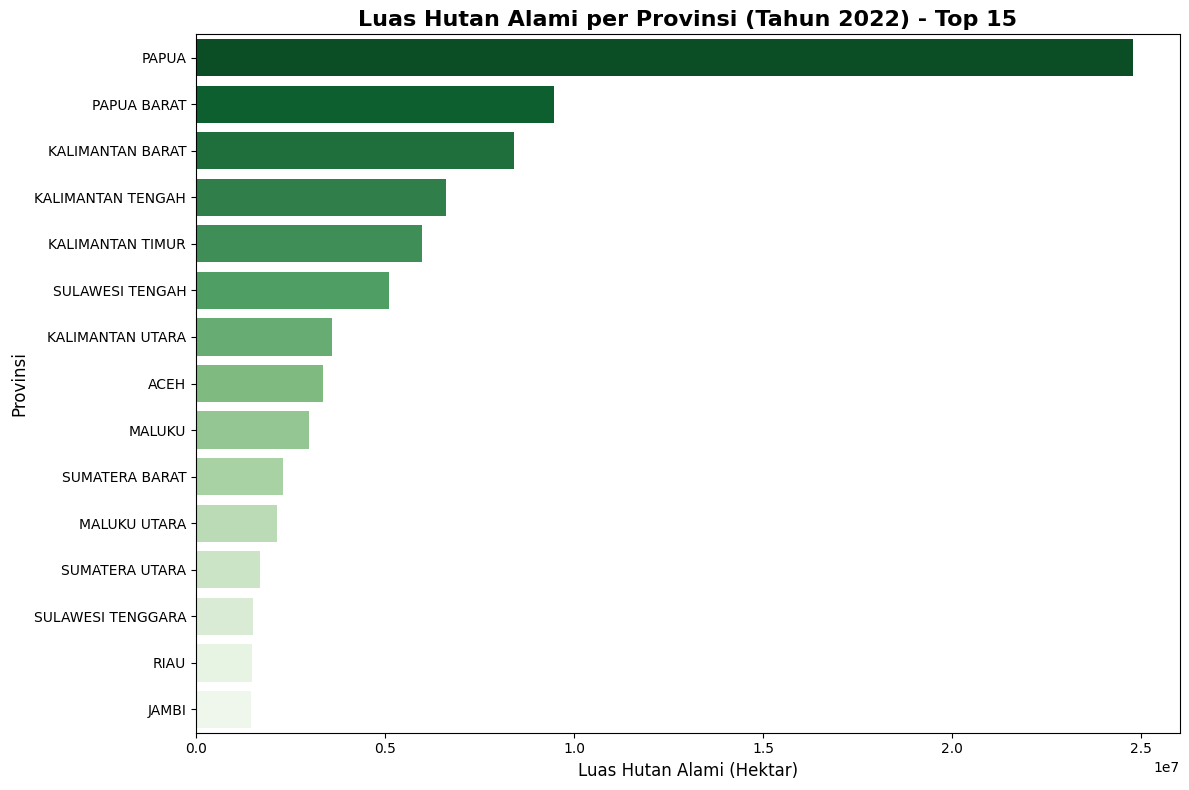

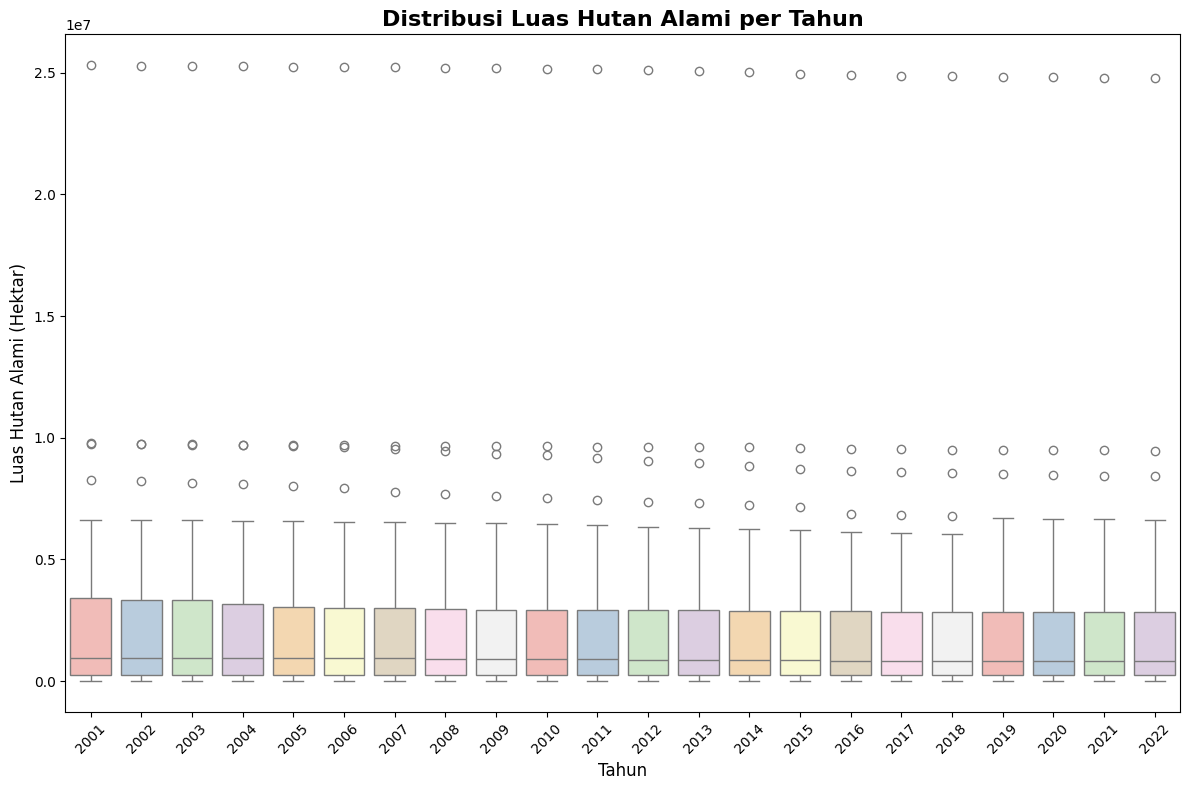

In [ ]:
# --- EDA untuk Data Luas Hutan Alami (Natural Forest Area) ---
if forest_df is not None:
    print("\n\n Analisis Data Eksploratif: Luas Hutan Alami per Provinsi ")
    print("-" * 60)

    print("\n Informasi Dataset Luas Hutan Alami:")
    forest_df.info()

    print("\n Statistik Deskriptif Luas Hutan Alami:")
    display(forest_df.describe(include='all'))

    print("\n Pengecekan Nilai Hilang Luas Hutan Alami:")
    display(forest_df.isnull().sum())

    # Visualisasi untuk Luas Hutan Alami
    # Tren Tahunan Luas Hutan Alami per Wilayah Induk (Parent Region)
    plt.figure()
    forest_trend_parent = forest_df.groupby(['year', 'parent_region'])['natural_forest_area_hectares'].sum().unstack()
    forest_trend_parent.plot(kind='line', marker='o', ax=plt.gca())
    plt.title('Tren Tahunan Luas Hutan Alami per Wilayah Induk', fontsize=16, fontweight='bold')
    plt.xlabel('Tahun', fontsize=12)
    plt.ylabel('Total Luas Hutan Alami (Hektar)', fontsize=12)
    plt.legend(title='Wilayah Induk', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Distribusi Luas Hutan Alami pada Tahun Terakhir
    if not forest_df.empty:
        latest_year_forest = forest_df['year'].max()
        plt.figure()
        forest_latest_year_data = forest_df[forest_df['year'] == latest_year_forest].sort_values(by='natural_forest_area_hectares', ascending=False)
        sns.barplot(x='natural_forest_area_hectares', y='region', data=forest_latest_year_data.head(15), palette='Greens_r')
        plt.title(f'Luas Hutan Alami per Provinsi (Tahun {latest_year_forest}) - Top 15', fontsize=16, fontweight='bold')
        plt.xlabel('Luas Hutan Alami (Hektar)', fontsize=12)
        plt.ylabel('Provinsi', fontsize=12)
        plt.tight_layout()
        plt.show()

    # Boxplot Distribusi Luas Hutan Alami per Tahun
    plt.figure()
    sns.boxplot(x='year', y='natural_forest_area_hectares', data=forest_df, palette='Pastel1')
    plt.title('Distribusi Luas Hutan Alami per Tahun', fontsize=16, fontweight='bold')
    plt.xlabel('Tahun', fontsize=12)
    plt.ylabel('Luas Hutan Alami (Hektar)', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("\nDataset Luas Hutan Alami tidak berhasil dimuat. EDA dilewati.")



 Analisis Data Eksploratif: Deforestasi per Provinsi 
------------------------------------------------------------

 Informasi Dataset Deforestasi:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 8 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   year                    748 non-null    int64  
 1   country                 748 non-null    object 
 2   country_iso2            748 non-null    object 
 3   region                  748 non-null    object 
 4   region_trase_id         748 non-null    object 
 5   parent_region           748 non-null    object 
 6   parent_region_trase_id  748 non-null    object 
 7   deforestation_hectares  748 non-null    float64
dtypes: float64(1), int64(1), object(6)
memory usage: 46.9+ KB

 Statistik Deskriptif Deforestasi:


,year,country,country_iso2,region,region_trase_id,parent_region,parent_region_trase_id,deforestation_hectares
count,748.000000,748,748,748,748,748,748,748.000000
unique,NaN,1,1,34,34,7,7,NaN
top,NaN,INDONESIA,ID,ACEH,ID-11,SUMATERA,ID-SM,NaN
freq,NaN,748,748,22,22,220,220,NaN
mean,2011.500000,NaN,NaN,NaN,NaN,NaN,NaN,13898.697182
std,6.348534,NaN,NaN,NaN,NaN,NaN,NaN,28894.803285
min,2001.000000,NaN,NaN,NaN,NaN,NaN,NaN,0.000000
25%,2006.000000,NaN,NaN,NaN,NaN,NaN,NaN,417.120441
50%,2011.500000,NaN,NaN,NaN,NaN,NaN,NaN,2950.012412
75%,2017.000000,NaN,NaN,NaN,NaN,NaN,NaN,14626.305000



 Pengecekan Nilai Hilang Deforestasi:


,0
year,0
country,0
country_iso2,0
region,0
region_trase_id,0
parent_region,0
parent_region_trase_id,0
deforestation_hectares,0


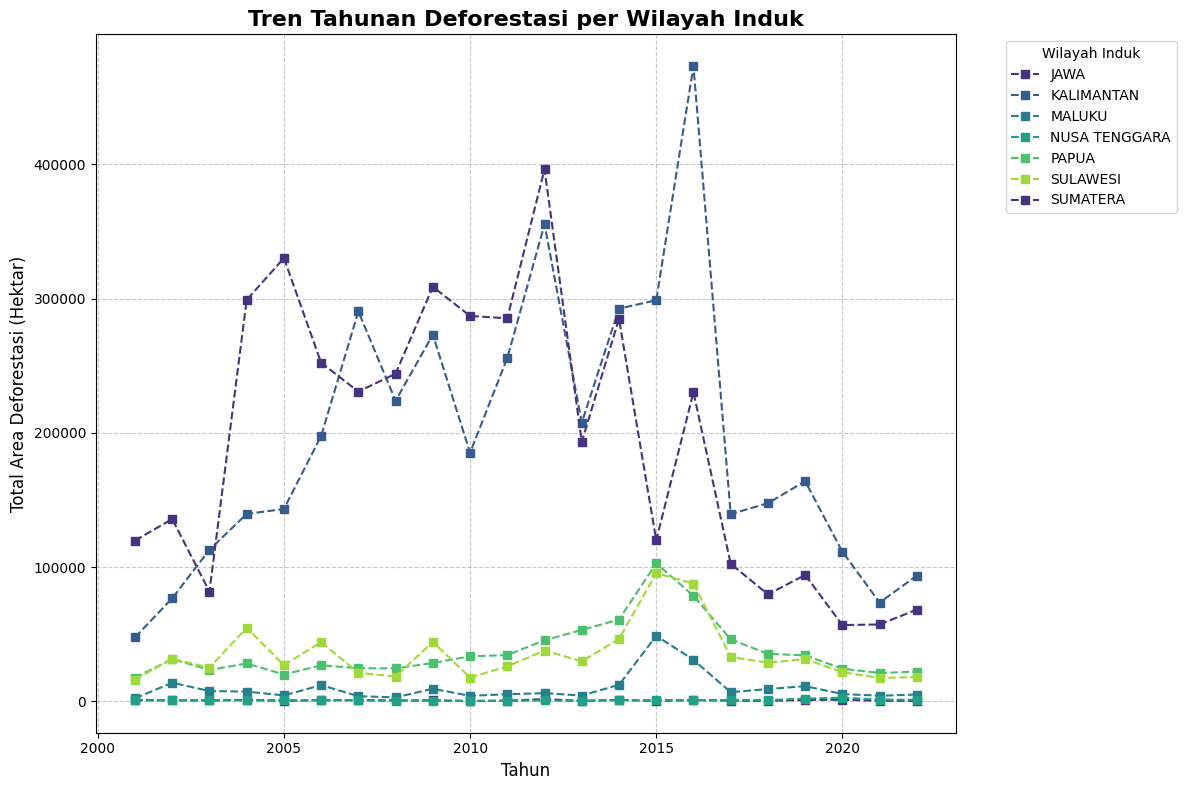

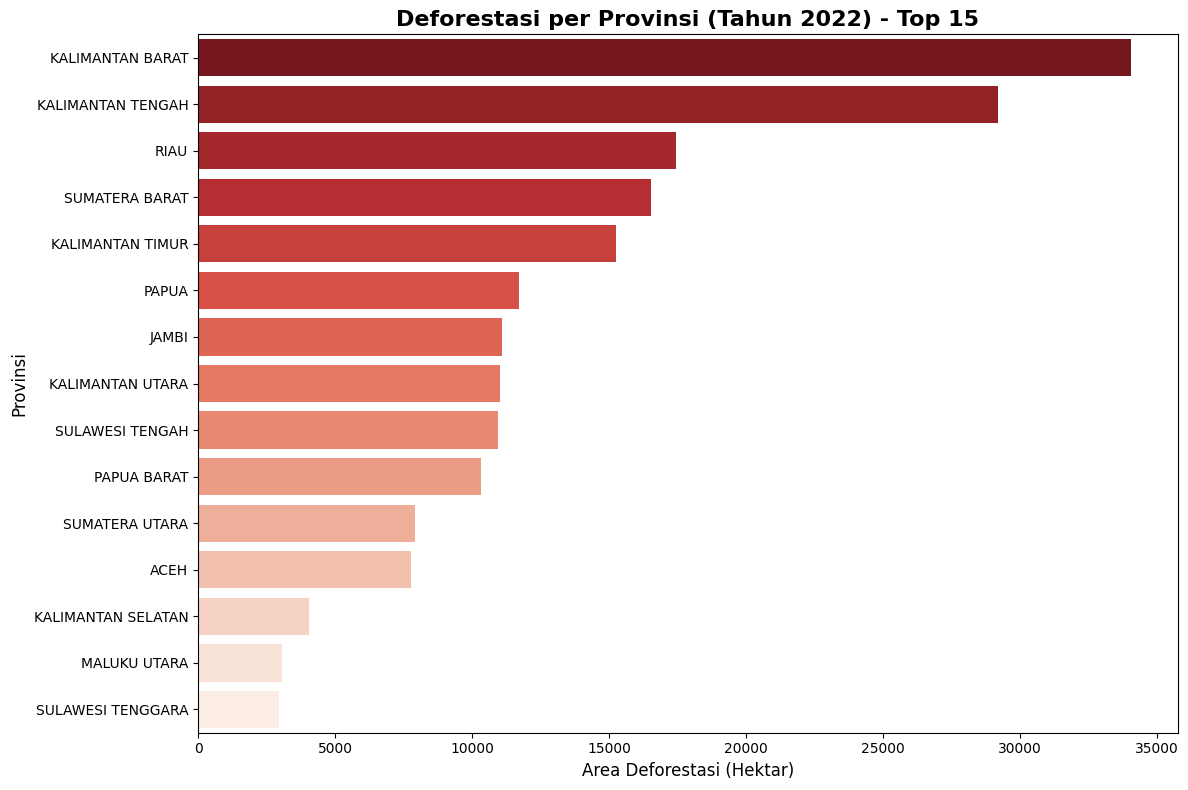

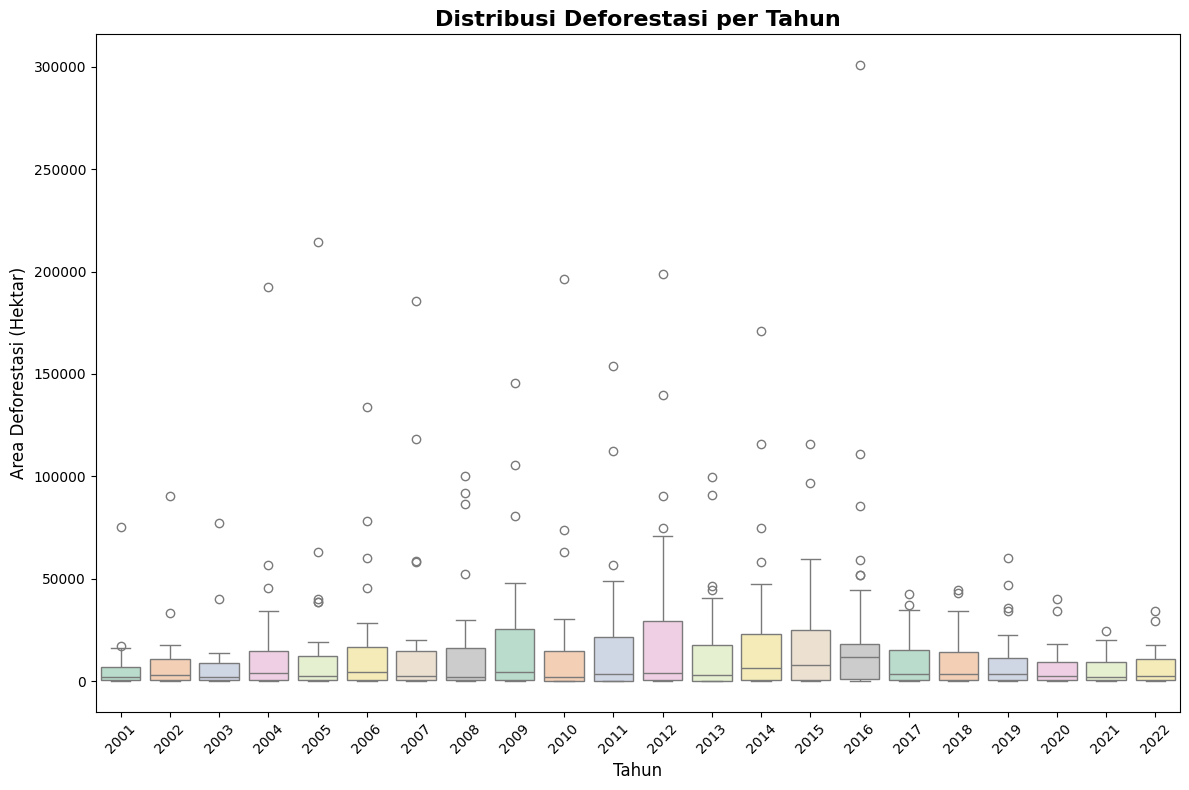

In [ ]:
# --- EDA untuk Data Deforestasi ---
if deforest_df is not None:
    print("\n\n Analisis Data Eksploratif: Deforestasi per Provinsi ")
    print("-" * 60)

    print("\n Informasi Dataset Deforestasi:")
    deforest_df.info()

    print("\n Statistik Deskriptif Deforestasi:")
    display(deforest_df.describe(include='all'))

    print("\n Pengecekan Nilai Hilang Deforestasi:")
    display(deforest_df.isnull().sum())

    # Visualisasi untuk Deforestasi
    # Tren Tahunan Deforestasi per Wilayah Induk (Parent Region)
    plt.figure()
    deforest_trend_parent = deforest_df.groupby(['year', 'parent_region'])['deforestation_hectares'].sum().unstack()
    deforest_trend_parent.plot(kind='line', marker='s', linestyle='--', ax=plt.gca())
    plt.title('Tren Tahunan Deforestasi per Wilayah Induk', fontsize=16, fontweight='bold')
    plt.xlabel('Tahun', fontsize=12)
    plt.ylabel('Total Area Deforestasi (Hektar)', fontsize=12)
    plt.legend(title='Wilayah Induk', bbox_to_anchor=(1.05, 1), loc='upper left')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

    # Distribusi Deforestasi pada Tahun Terakhir
    if not deforest_df.empty:
        latest_year_deforest = deforest_df['year'].max()
        plt.figure()
        deforest_latest_year_data = deforest_df[deforest_df['year'] == latest_year_deforest].sort_values(by='deforestation_hectares', ascending=False)
        sns.barplot(x='deforestation_hectares', y='region', data=deforest_latest_year_data.head(15), palette='Reds_r')
        plt.title(f'Deforestasi per Provinsi (Tahun {latest_year_deforest}) - Top 15', fontsize=16, fontweight='bold')
        plt.xlabel('Area Deforestasi (Hektar)', fontsize=12)
        plt.ylabel('Provinsi', fontsize=12)
        plt.tight_layout()
        plt.show()

    # Boxplot Distribusi Deforestasi per Tahun
    plt.figure()
    sns.boxplot(x='year', y='deforestation_hectares', data=deforest_df, palette='Pastel2')
    plt.title('Distribusi Deforestasi per Tahun', fontsize=16, fontweight='bold')
    plt.xlabel('Tahun', fontsize=12)
    plt.ylabel('Area Deforestasi (Hektar)', fontsize=12)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
else:
    print("\nDataset Deforestasi tidak berhasil dimuat. EDA dilewati.")

# **Data Cleaning**

In [4]:
# Data preprocessing
forest_df['natural_forest_area_hectares'] = pd.to_numeric(forest_df['natural_forest_area_hectares'], errors='coerce')
deforest_df['deforestation_hectares'] = pd.to_numeric(deforest_df['deforestation_hectares'], errors='coerce')

# Merge datasets
merged_df = pd.merge(forest_df, deforest_df, on=['year', 'region'], suffixes=('_forest', '_deforest'))
merged_df = merged_df.sort_values(['region', 'year']).reset_index(drop=True)
merged_df = merged_df.dropna(subset=['natural_forest_area_hectares', 'deforestation_hectares'])

selected_columns = [
    'year',
    'country_forest',
    'country_iso2_forest',
    'region',
    'region_trase_id_forest',
    'parent_region_forest',
    'parent_region_trase_id_forest',
    'natural_forest_area_hectares',
    'deforestation_hectares'
]

# Filter hanya kolom yang diperlukan
filtered_df = merged_df[selected_columns].drop_duplicates()

# Save Dataset
output_filename = "combined_spatial_data.csv"
filtered_df.to_csv(output_filename, index=False)

COL_YEAR = 'year'                            # Nama kolom untuk tahun
COL_PROVINCE = 'region'                        # Nama kolom untuk provinsi
COL_FOREST_AREA = 'natural_forest_area_hectares' # Nama kolom untuk luas hutan alam
COL_ISLAND = 'parent_region'               # Opsional: Nama kolom untuk pulau, jika ada
COL_FOREST_DEF = 'deforestation_hectares'    # Nama kolom untuk deforestasi

print(f"Memulai Analisis Data Eksploratif (EDA) untuk 'Prediksi Luas Hutan Alam Tersisa di Kabupaten/Kota di Indonesia (2001–2020)'")

# --- EDA Utama ---
if filtered_df is not None:

    # 1. Tinjauan Awal Data
    print("\n--- 1. Tinjauan Awal Data ---")
    print("\n(a) Menampilkan 5 Baris Pertama (df.head()):")
    display(filtered_df.head())

    print("\n(b) Bentuk DataFrame (df.shape):")
    print(f"{filtered_df.shape[0]:,} baris x {filtered_df.shape[1]} kolom")

    print("\n(c) Menampilkan Info Dataframe (df.info()):")
    filtered_df.info()

    print("\n(d) Tipe Data (df.dtypes):")
    print(filtered_df.dtypes)

    print("\n(e) Deskripsi Statistik (df.describe()):")
    display(filtered_df.describe())

    # Statistik provinsi
    print(f"\n(f) Ringkasan Provinsi ('{COL_PROVINCE}'):")
    print(f"• Jumlah provinsi unik: {filtered_df[COL_PROVINCE].nunique()}")
    province_counts = filtered_df[COL_PROVINCE].value_counts().head(10)

    # Statistik tahun
    print(f"\n (g) Ringkasan Tahun ('{COL_YEAR}'):")
    year_counts = filtered_df[COL_YEAR].value_counts().sort_index()
    print(f"• Distribusi data per tahun:")
    for year, count in year_counts.items():
        print(f"  - {int(year)}: {count:,} data points")

Memulai Analisis Data Eksploratif (EDA) untuk 'Prediksi Luas Hutan Alam Tersisa di Kabupaten/Kota di Indonesia (2001–2020)'

--- 1. Tinjauan Awal Data ---

(a) Menampilkan 5 Baris Pertama (df.head()):


,year,country_forest,country_iso2_forest,region,region_trase_id_forest,parent_region_forest,parent_region_trase_id_forest,natural_forest_area_hectares,deforestation_hectares
0,2001,INDONESIA,ID,ACEH,ID-11,SUMATERA,ID-SM,3.624507e+06,4097.692235
1,2002,INDONESIA,ID,ACEH,ID-11,SUMATERA,ID-SM,3.621571e+06,2935.927765
2,2003,INDONESIA,ID,ACEH,ID-11,SUMATERA,ID-SM,3.615809e+06,5761.893176
3,2004,INDONESIA,ID,ACEH,ID-11,SUMATERA,ID-SM,3.610221e+06,5588.036118
4,2005,INDONESIA,ID,ACEH,ID-11,SUMATERA,ID-SM,3.600450e+06,9770.899765



(b) Bentuk DataFrame (df.shape):
748 baris x 9 kolom

(c) Menampilkan Info Dataframe (df.info()):
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 748 entries, 0 to 747
Data columns (total 9 columns):
 #   Column                         Non-Null Count  Dtype  
---  ------                         --------------  -----  
 0   year                           748 non-null    int64  
 1   country_forest                 748 non-null    object 
 2   country_iso2_forest            748 non-null    object 
 3   region                         748 non-null    object 
 4   region_trase_id_forest         748 non-null    object 
 5   parent_region_forest           748 non-null    object 
 6   parent_region_trase_id_forest  748 non-null    object 
 7   natural_forest_area_hectares   748 non-null    float64
 8   deforestation_hectares         748 non-null    float64
dtypes: float64(2), int64(1), object(6)
memory usage: 52.7+ KB

(d) Tipe Data (df.dtypes):
year                               int64
count

,year,natural_forest_area_hectares,deforestation_hectares
count,748.000000,7.480000e+02,748.000000
mean,2011.500000,2.705803e+06,13898.697182
std,6.348534,4.683202e+06,28894.803285
min,2001.000000,9.720000e+00,0.000000
25%,2006.000000,2.548762e+05,417.120441
50%,2011.500000,8.713053e+05,2950.012412
75%,2017.000000,3.074278e+06,14626.305000
max,2022.000000,2.530910e+07,300781.703647



(f) Ringkasan Provinsi ('region'):
• Jumlah provinsi unik: 34

 (g) Ringkasan Tahun ('year'):
• Distribusi data per tahun:
  - 2001: 34 data points
  - 2002: 34 data points
  - 2003: 34 data points
  - 2004: 34 data points
  - 2005: 34 data points
  - 2006: 34 data points
  - 2007: 34 data points
  - 2008: 34 data points
  - 2009: 34 data points
  - 2010: 34 data points
  - 2011: 34 data points
  - 2012: 34 data points
  - 2013: 34 data points
  - 2014: 34 data points
  - 2015: 34 data points
  - 2016: 34 data points
  - 2017: 34 data points
  - 2018: 34 data points
  - 2019: 34 data points
  - 2020: 34 data points
  - 2021: 34 data points
  - 2022: 34 data points


# ARIMAX Model

## Pre-processing Dataset

In [5]:
file_path = 'combined_spatial_data.csv'

# Memuat dataset
try:
    df = pd.read_csv(file_path)
    print(f"Dataset loaded from '{file_path}'.")
except FileNotFoundError:
    print(f"Error: File '{file_path}' tidak ditemukan. Pastikan nama file dan path sudah benar.")
    exit()

Dataset loaded from 'combined_spatial_data.csv'.


In [6]:
# --- Persiapan Data untuk Satu Wilayah (Contoh: ACEH) ---
nama_wilayah = 'ACEH'
df_region = df[df['region'] == nama_wilayah].copy()

if df_region.empty:
    print(f"\nError: Tidak ada data untuk wilayah '{nama_wilayah}'.")
    exit()

print(f"\nData untuk wilayah: {nama_wilayah}")
display(df_region.head(3)) # Tampilkan beberapa baris saja

# Mengatur 'year' sebagai index datetime
df_region['date'] = pd.to_datetime(df_region['year'], format='%Y')
df_region.set_index('date', inplace=True)

# Memilih variabel target (y) dan variabel eksogen (X)
target_variable = 'natural_forest_area_hectares'
exog_variable = 'deforestation_hectares'

# Pengecekan nilai NaN
print(f"\nJumlah NaN di '{target_variable}' ({nama_wilayah}): {df_region[target_variable].isnull().sum()}")
print(f"Jumlah NaN di '{exog_variable}' ({nama_wilayah}): {df_region[exog_variable].isnull().sum()}")

y = df_region[target_variable]
X = df_region[[exog_variable]] # Variabel eksogen harus dalam bentuk DataFrame 2D

print(f"\nVariabel Target (y) - {nama_wilayah} (awal):")
display(y.head(3))
print(f"Variabel Eksogen (X) - {nama_wilayah} (awal):")
display(X.head(3))

print(f"\nPanjang deret waktu y: {len(y)}")
print(f"Panjang deret waktu X: {len(X)}")

if len(y) != len(X):
    print("Peringatan: Panjang y dan X tidak sama!")


Data untuk wilayah: ACEH


,year,country_forest,country_iso2_forest,region,region_trase_id_forest,parent_region_forest,parent_region_trase_id_forest,natural_forest_area_hectares,deforestation_hectares
0,2001,INDONESIA,ID,ACEH,ID-11,SUMATERA,ID-SM,3.624507e+06,4097.692235
1,2002,INDONESIA,ID,ACEH,ID-11,SUMATERA,ID-SM,3.621571e+06,2935.927765
2,2003,INDONESIA,ID,ACEH,ID-11,SUMATERA,ID-SM,3.615809e+06,5761.893176



Jumlah NaN di 'natural_forest_area_hectares' (ACEH): 0
Jumlah NaN di 'deforestation_hectares' (ACEH): 0

Variabel Target (y) - ACEH (awal):


,natural_forest_area_hectares
date,
2001-01-01,3.624507e+06
2002-01-01,3.621571e+06
2003-01-01,3.615809e+06


Variabel Eksogen (X) - ACEH (awal):


,deforestation_hectares
date,
2001-01-01,4097.692235
2002-01-01,2935.927765
2003-01-01,5761.893176



Panjang deret waktu y: 22
Panjang deret waktu X: 22


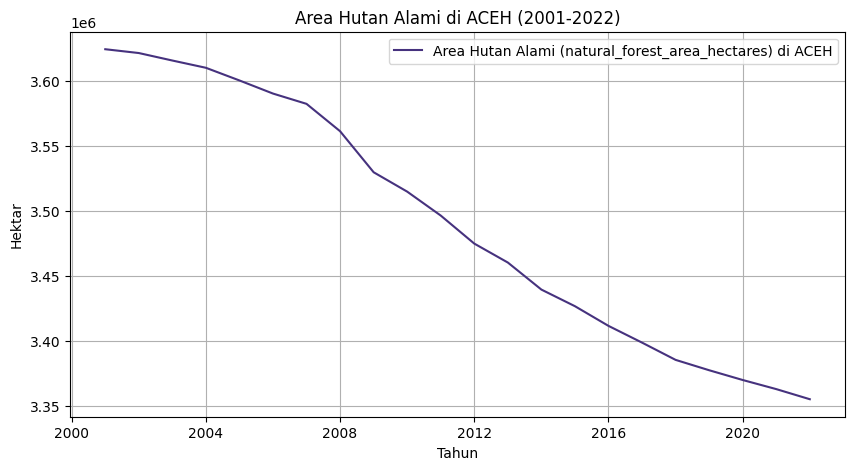

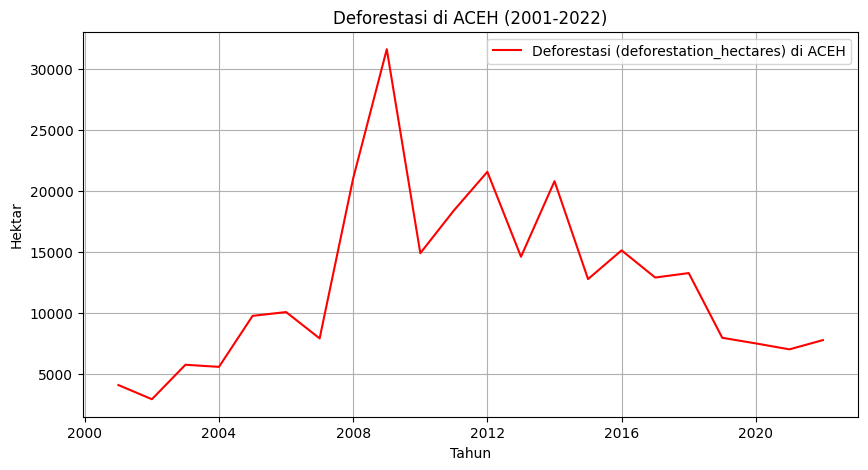


Plot ACF dan PACF untuk 'natural_forest_area_hectares' di ACEH (Original):


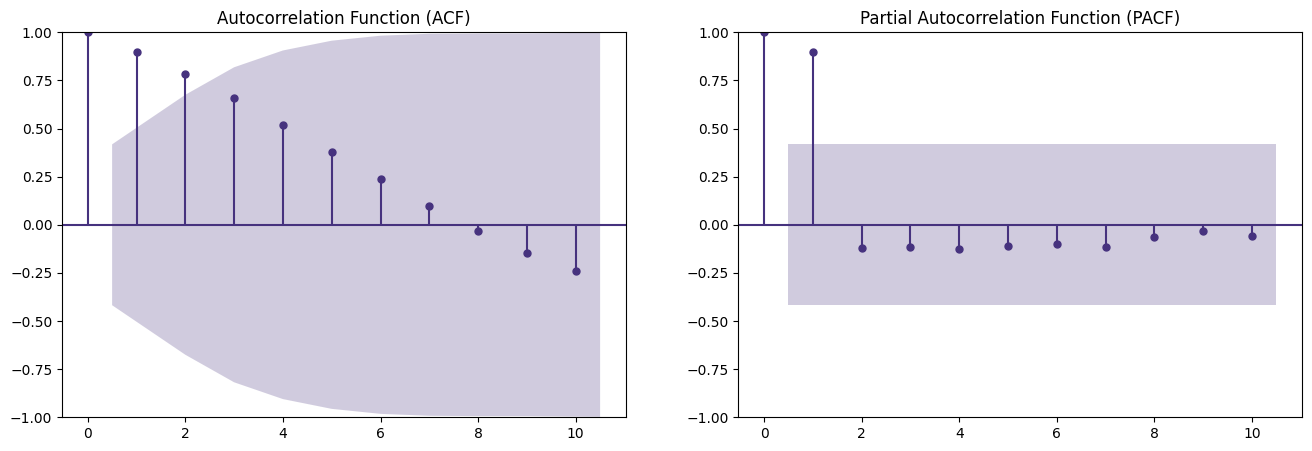

In [7]:
# Visualisasi Variabel Target
plt.figure(figsize=(10, 5))
plt.plot(y, label=f'Area Hutan Alami ({target_variable}) di {nama_wilayah}')
plt.title(f'Area Hutan Alami di {nama_wilayah} (2001-2022)')
plt.xlabel('Tahun')
plt.ylabel('Hektar')
plt.legend()
plt.grid(True)
plt.show()

# Visualisasi Variabel Eksogen
plt.figure(figsize=(10, 5))
plt.plot(X[exog_variable], label=f'Deforestasi ({exog_variable}) di {nama_wilayah}', color='red')
plt.title(f'Deforestasi di {nama_wilayah} (2001-2022)')
plt.xlabel('Tahun')
plt.ylabel('Hektar')
plt.legend()
plt.grid(True)
plt.show()

# Plot ACF dan PACF untuk Variabel Target (Original)
print(f"\nPlot ACF dan PACF untuk '{target_variable}' di {nama_wilayah} (Original):")
fig, axes = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(y, ax=axes[0], lags=min(10, len(y)//2 - 1))
plot_pacf(y, ax=axes[1], lags=min(10, len(y)//2 - 1))
axes[0].set_title('Autocorrelation Function (ACF)')
axes[1].set_title('Partial Autocorrelation Function (PACF)')
plt.show()

In [8]:
# Uji Stasioneritas dengan Augmented Dickey-Fuller Test
print(f"\nHasil Uji ADF untuk '{target_variable}' di {nama_wilayah} (Original):")
adf_result = adfuller(y)
print(f'\nADF Statistic: {adf_result[0]}')
print(f'p-value: {adf_result[1]}')
print('Critical Values:')
for key, value in adf_result[4].items():
    print(f'\t{key}: {value}')

d = 0
y_differenced = y.copy()

if adf_result[1] > 0.05:
    print(f"P-value ({adf_result[1]:.4f}) > 0.05, data '{target_variable}' kemungkinan tidak stasioner.")
    print("Melakukan differencing...")

    y_differenced = y.diff().dropna()
    d = 1

    print(f"Plot ACF dan PACF untuk '{target_variable}' (Setelah 1st Differencing):")
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    plot_acf(y_differenced, ax=axes[0], lags=min(10, len(y_differenced)//2 - 1))
    plot_pacf(y_differenced, ax=axes[1], lags=min(10, len(y_differenced)//2 - 1))
    axes[0].set_title('ACF (1st Differencing)')
    axes[1].set_title('PACF (1st Differencing)')
    plt.show()

    print(f"Hasil Uji ADF untuk '{target_variable}' (Setelah 1st Differencing):")
    adf_result_diff = adfuller(y_differenced)
    print(f'ADF Statistic: {adf_result_diff[0]}')
    print(f'p-value: {adf_result_diff[1]}')

    if adf_result_diff[1] > 0.05:
        print(f"P-value ({adf_result_diff[1]:.4f}) > 0.05, data masih belum stasioner setelah 1st differencing.")
        print("Mencoba 2nd differencing (jarang diperlukan, hati-hati over-differencing)...")

        y_differenced = y.diff().diff().dropna()
        d = 2

        print(f"Plot ACF dan PACF untuk '{target_variable}' (Setelah 2nd Differencing):")
        fig, axes = plt.subplots(1, 2, figsize=(16, 5))
        plot_acf(y_differenced, ax=axes[0], lags=min(10, len(y_differenced)//2 - 1))
        plot_pacf(y_differenced, ax=axes[1], lags=min(10, len(y_differenced)//2 - 1))
        axes[0].set_title('ACF (2nd Differencing)')
        axes[1].set_title('PACF (2nd Differencing)')
        plt.show()

        adf_result_diff2 = adfuller(y_differenced)
        print(f"Hasil Uji ADF untuk '{target_variable}' (Setelah 2nd Differencing):")
        print(f'ADF Statistic: {adf_result_diff2[0]}')
        print(f'p-value: {adf_result_diff2[1]}')

        if adf_result_diff2[1] <= 0.05:
            print(f"Data menjadi stasioner setelah 2nd differencing (d={d}).")
        else:
            print(f"Data mungkin masih belum stasioner setelah 2nd differencing atau memerlukan pendekatan lain.")
    else:
        print(f"Data menjadi stasioner setelah 1st differencing (d={d}).")
else:
    print(f"P-value ({adf_result[1]:.4f}) <= 0.05, data '{target_variable}'")

print(f"Orde differencing (d) yang akan digunakan: {d}")


Hasil Uji ADF untuk 'natural_forest_area_hectares' di ACEH (Original):

ADF Statistic: -3.4870828446939273
p-value: 0.008325097557322119
Critical Values:
	1%: -3.9644434814814815
	5%: -3.0849081481481484
	10%: -2.6818144444444445
P-value (0.0083) <= 0.05, data 'natural_forest_area_hectares'
Orde differencing (d) yang akan digunakan: 0


## Build ARIMAX Model

Plot ACF dan PACF untuk 'natural_forest_area_hectares' yang sudah distasionerkan (jika d>0):


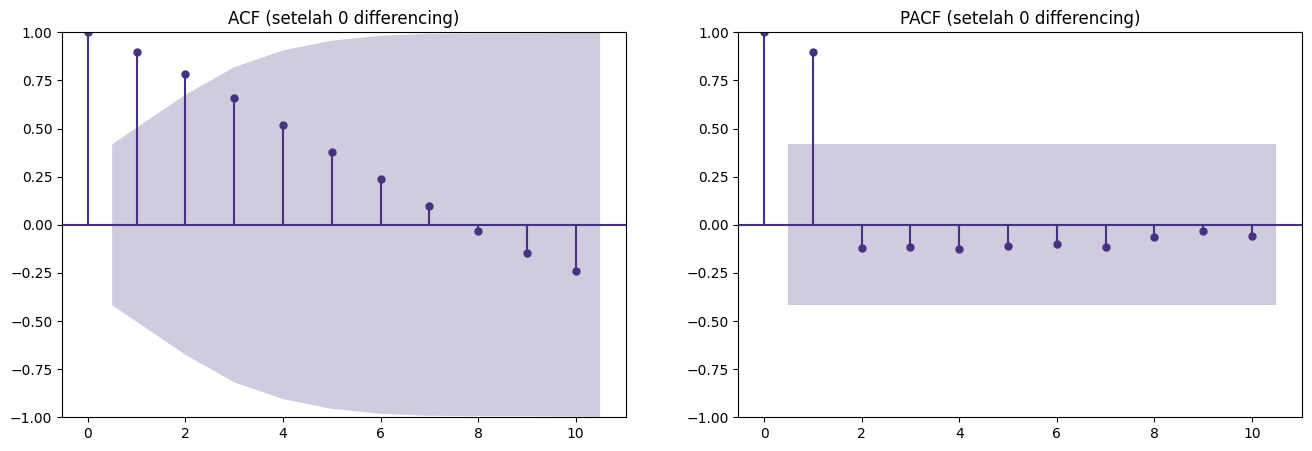

Orde yang akan dicoba: p=1, d=0, q=1


In [9]:
# ARIMAX MODEL FITTING AND PARAMETER ESTIMATION

# Data Preparation for ARIMAX Modeling
y_fit = y
X_fit = X

# ACF/PACF Visualization for Stationary Data
print(f"Plot ACF dan PACF untuk '{target_variable}' yang sudah distasionerkan (jika d>0):")

data_for_acf_pacf = y_differenced if d > 0 else y

fig, axes = plt.subplots(1, 2, figsize=(16, 5))
plot_acf(data_for_acf_pacf, ax=axes[0], lags=min(10, len(data_for_acf_pacf)//2 - 1))
plot_pacf(data_for_acf_pacf, ax=axes[1], lags=min(10, len(data_for_acf_pacf)//2 - 1))
axes[0].set_title(f'ACF (setelah {d} differencing)')
axes[1].set_title(f'PACF (setelah {d} differencing)')
plt.show()

# ARIMAX Parameter Determination
p = 1  # AR order - sesuaikan berdasarkan PACF plot
q = 1  # MA order - sesuaikan berdasarkan ACF plot

print(f"Orde yang akan dicoba: p={p}, d={d}, q={q}")

## **Train ARIMAX Model**


-------------------RINGKASAN MODEL ARIMAX-------------------
                                    SARIMAX Results                                     
Dep. Variable:     natural_forest_area_hectares   No. Observations:                   22
Model:                           ARIMA(1, 0, 1)   Log Likelihood                -231.243
Date:                          Thu, 29 May 2025   AIC                            472.486
Time:                                  18:09:36   BIC                            477.941
Sample:                              01-01-2001   HQIC                           473.771
                                   - 01-01-2022                                         
Covariance Type:                            opg                                         
                             coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------------------
const                   3.516e+06   2.85e+05

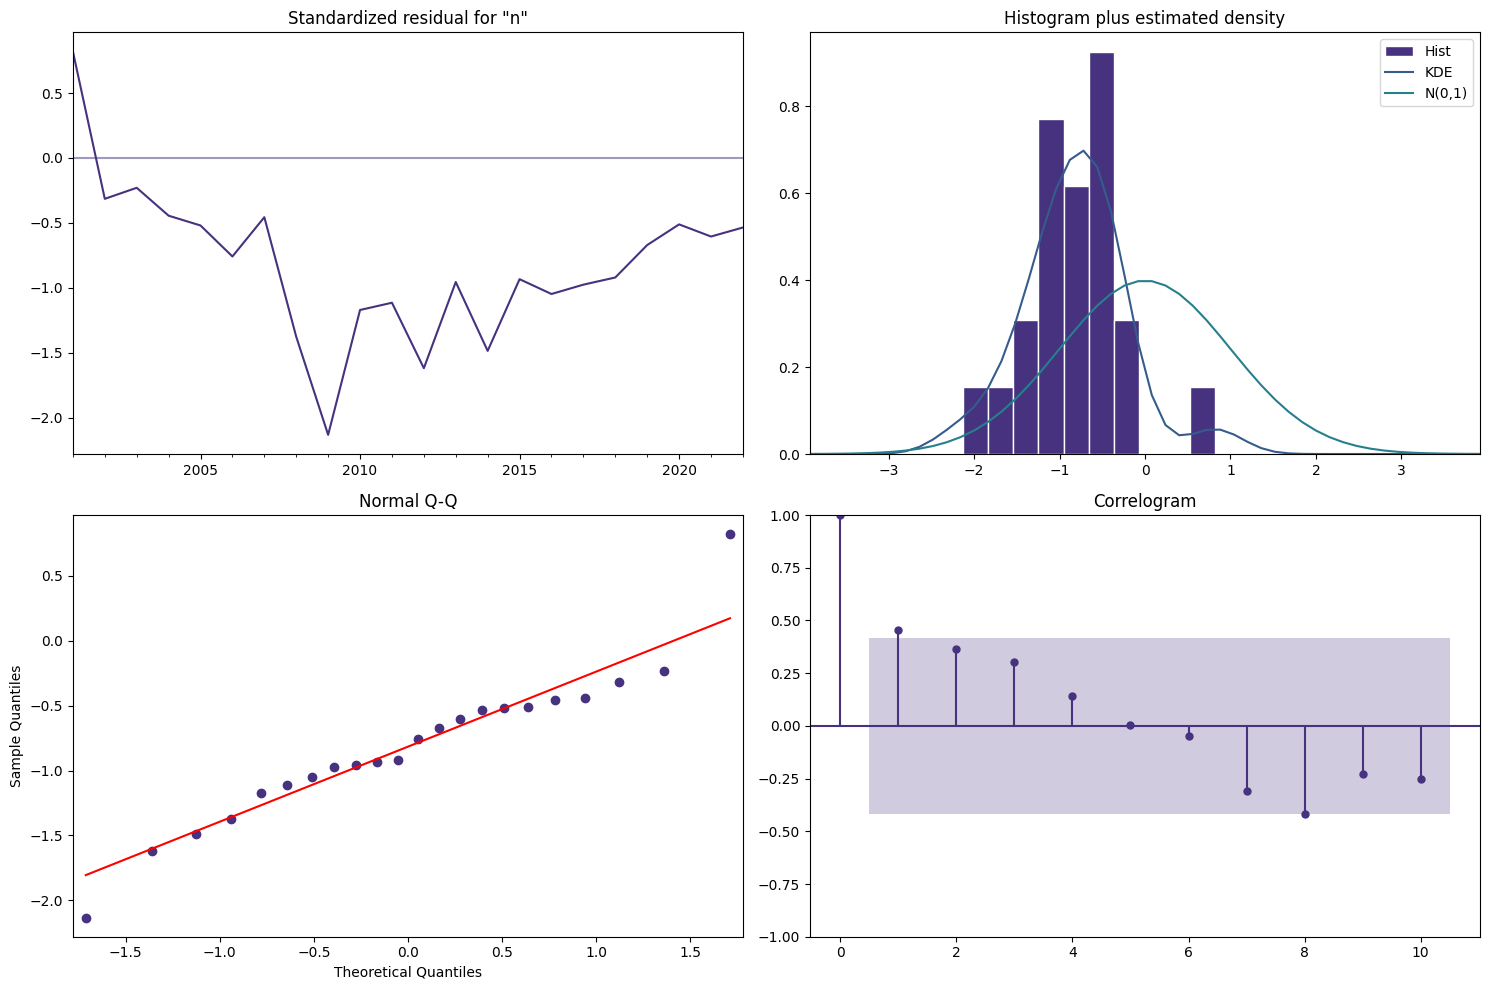

In [10]:
# ARIMAX Model Fitting
from statsmodels.tsa.arima.model import ARIMA

try:
    model = ARIMA(endog=y_fit, exog=X_fit, order=(p, d, q))
    results = model.fit()

    print("\n" + "="*60)
    print("-"*19 + "RINGKASAN MODEL ARIMAX" + "-"*19)
    print("="*60)
    print(results.summary())

    # Model Diagnostics Visualization
    print("\n" + "="*60)
    print("-"*19 + "PLOT DIAGNOSTIK MODEL" + "-"*19)
    print("="*60)

    results.plot_diagnostics(figsize=(15, 10))
    plt.tight_layout()
    plt.show()

except Exception as e:
    print(f"Error saat fitting model ARIMAX: {e}")
    print("Kemungkinan penyebab:")
    print("- Orde (p,d,q) yang tidak sesuai.")
    print("- Masalah dengan data eksogen (X_fit), pastikan tidak ada NaN dan panjangnya sesuai.")
    print("- Masalah konvergensi (coba metode solver berbeda atau sederhanakan model).")

Jumlah periode peramalan: 8 tahun (2023-2030)
Nilai eksogen terakhir (deforestation_hectares) yang diketahui (tahun 2022): 7783.71564705888
Contoh X_future (menggunakan nilai konstan terakhir dari deforestation_hectares):
            deforestation_hectares
2023-01-01             7783.715647
2024-01-01             7783.715647
2025-01-01             7783.715647
2026-01-01             7783.715647
2027-01-01             7783.715647
2028-01-01             7783.715647
2029-01-01             7783.715647
2030-01-01             7783.715647

--------------------HASIL PERAMALAN--------------------
Tahun		Perkiraan Area Hutan (Hektar)	Batas Bawah 95% CI	Batas Atas 95% CI
2023		3352140.15			3337604.38			3366675.93
2024		3353073.83			3321216.69			3384930.97
2025		3354002.06			3311468.19			3396535.94
2026		3354924.89			3303992.03			3405857.75
2027		3355842.34			3297790.10			3413894.57
2028		3356754.44			3292435.29			3421073.60
2029		3357661.23			3287697.41			3427625.05
2030		3358562.74			3283435.43		

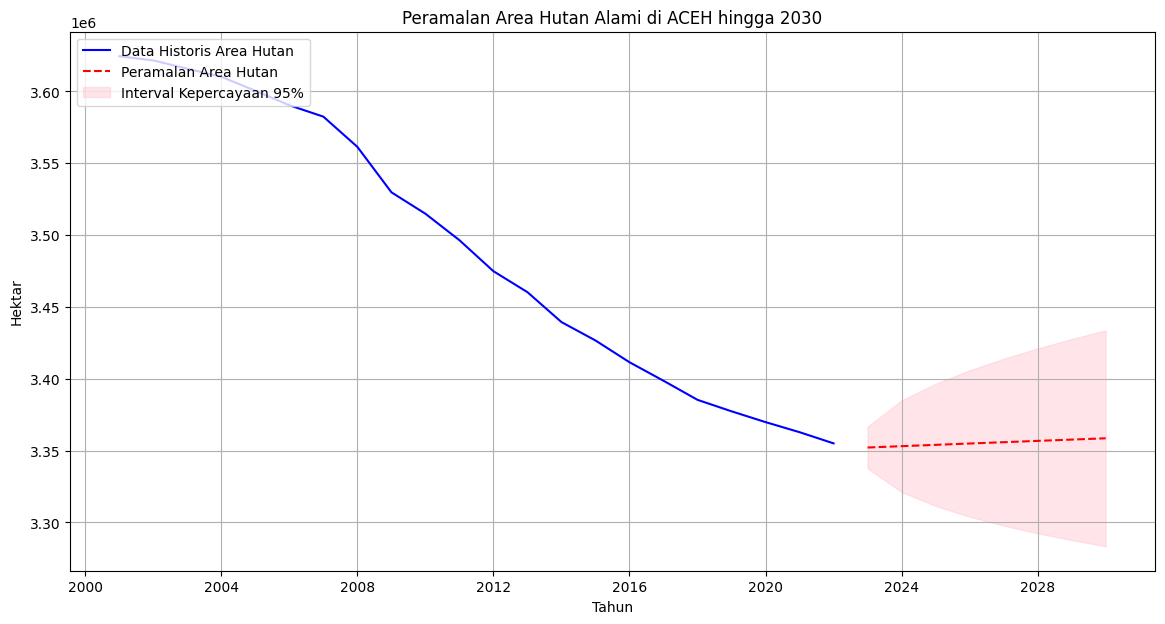

In [11]:
# Forecast Configuration
n_forecast_steps = 2030 - 2022
print(f"Jumlah periode peramalan: {n_forecast_steps} tahun (2023-{2022 + n_forecast_steps})")

# Future Exogenous Variables Preparation
last_known_exog_value = X[exog_variable].iloc[-1]
print(f"Nilai eksogen terakhir ({exog_variable}) yang diketahui (tahun 2022): {last_known_exog_value}")

future_years = pd.date_range(start=y.index[-1] + pd.DateOffset(years=1), periods=n_forecast_steps, freq='AS-JAN')
X_future = pd.DataFrame(index=future_years, columns=[exog_variable])

# Menggunakan nilai konstan (nilai terakhir)
X_future[exog_variable] = last_known_exog_value
print(f"Contoh X_future (menggunakan nilai konstan terakhir dari {exog_variable}):")
print(X_future)

# ARIMAX Forecasting
try:
    forecast_object = results.get_forecast(steps=n_forecast_steps, exog=X_future)

    y_forecast_mean = forecast_object.predicted_mean
    confidence_intervals = forecast_object.conf_int(alpha=0.05)
    lower_ci = confidence_intervals.iloc[:, 0]
    upper_ci = confidence_intervals.iloc[:, 1]

    print("\n" + "="*55)
    print("-"*20+"HASIL PERAMALAN"+"-"*20)
    print("="*55)
    print("Tahun\t\tPerkiraan Area Hutan (Hektar)\tBatas Bawah 95% CI\tBatas Atas 95% CI")
    for i in range(len(y_forecast_mean)):
        year_str = y_forecast_mean.index[i].strftime('%Y')
        print(f"{year_str}\t\t{y_forecast_mean.iloc[i]:.2f}\t\t\t{lower_ci.iloc[i]:.2f}\t\t\t{upper_ci.iloc[i]:.2f}")

    # Forecasting Results Visualization
    plt.figure(figsize=(14, 7))
    plt.plot(y.index, y, label='Data Historis Area Hutan', color='blue')
    plt.plot(y_forecast_mean.index, y_forecast_mean, label='Peramalan Area Hutan', color='red', linestyle='--')
    plt.fill_between(y_forecast_mean.index, lower_ci, upper_ci, color='pink', alpha=0.4, label='Interval Kepercayaan 95%')

    plt.title(f'Peramalan Area Hutan Alami di {nama_wilayah} hingga {2022 + n_forecast_steps}')
    plt.xlabel('Tahun')
    plt.ylabel('Hektar')
    plt.legend(loc='upper left')
    plt.grid(True)
    plt.show()

except Exception as e:
    print(f"Error saat melakukan peramalan: {e}")
    print("Pastikan X_future sudah benar (panjangnya sesuai dengan 'steps' dan memiliki kolom yang sama dengan X training).")

## Testing ARIMAX Model

Mencari parameter (p,q) terbaik untuk d=0 menggunakan AIC...
------------------------------------------------------------
Order: (0, 0, 1), AIC: 558.7807
Order: (0, 0, 2), AIC: 556.9374
Order: (1, 0, 0), AIC: 495.3311
Order: (1, 0, 1), AIC: 472.4858
Order: (1, 0, 2), AIC: 458.9172
Order: (2, 0, 0), AIC: 439.5173
Order: (2, 0, 1), AIC: 452.2619
Order: (2, 0, 2), AIC: 462.3498
------------------------------------------------------------
Model ARIMAX terbaik ditemukan untuk wilayah ACEH:
Order (p,d,q): (2, 0, 0)
AIC: 439.5173

RINGKASAN MODEL ARIMAX TERBAIK
                                    SARIMAX Results                                     
Dep. Variable:     natural_forest_area_hectares   No. Observations:                   22
Model:                           ARIMA(2, 0, 0)   Log Likelihood                -214.759
Date:                          Thu, 29 May 2025   AIC                            439.517
Time:                                  18:09:43   BIC                            44

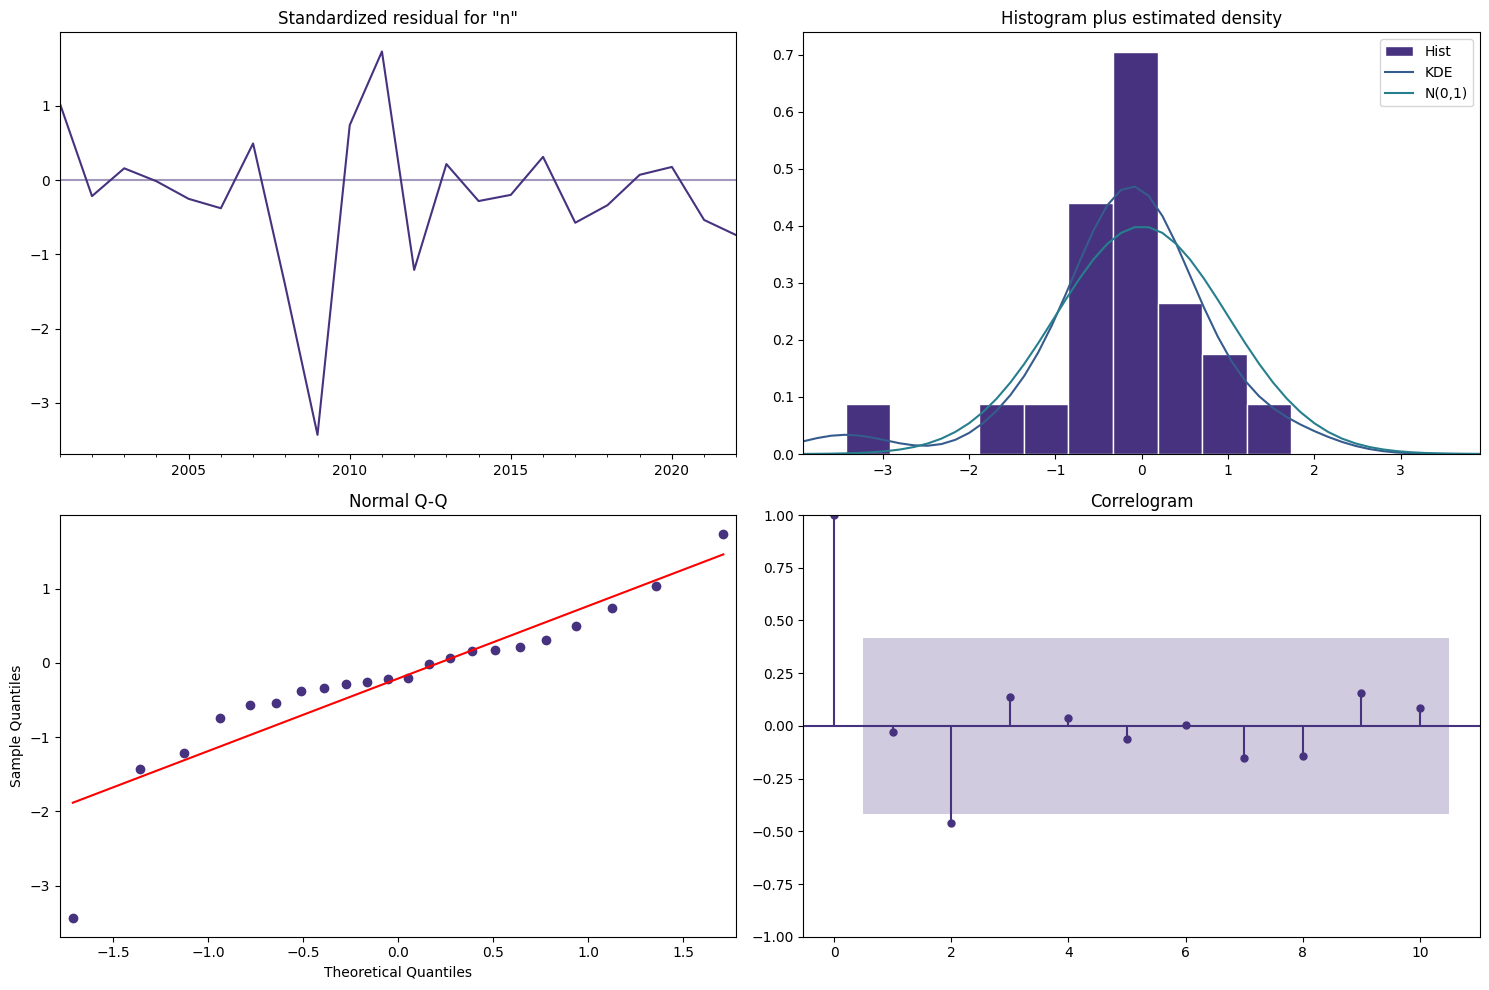

In [12]:
# Warning Settings for Optimization Process
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', HessianInversionWarning)
warnings.simplefilter('ignore', UserWarning)

# Parameter Grid Search Configuration
p_range = range(0, 3)
q_range = range(0, 3)

best_aic = float("inf")
best_order = None
best_model_results = None

print(f"Mencari parameter (p,q) terbaik untuk d={d} menggunakan AIC...")
print("-" * 60)

# Grid Search for Optimal Parameters
for p_val in p_range:
    for q_val in q_range:
        if p_val == 0 and d == 0 and q_val == 0:
            continue

        current_order = (p_val, d, q_val)
        try:
            model_iter = ARIMA(endog=y_fit, exog=X_fit, order=current_order)
            results_iter = model_iter.fit()

            current_aic = results_iter.aic
            print(f"Order: {current_order}, AIC: {current_aic:.4f}")

            if current_aic < best_aic:
                best_aic = current_aic
                best_order = current_order
                best_model_results = results_iter

        except Exception as e:
            continue

# Best Model Results
print("-" * 60)
if best_model_results:
    print(f"Model ARIMAX terbaik ditemukan untuk wilayah {nama_wilayah}:")
    print(f"Order (p,d,q): {best_order}")
    print(f"AIC: {best_aic:.4f}")

    print("\n" + "="*60)
    print("RINGKASAN MODEL ARIMAX TERBAIK")
    print("="*60)
    print(best_model_results.summary())

    # Best Model Diagnostics Visualization
    print("\n" + "="*60)
    print("PLOT DIAGNOSTIK MODEL TERBAIK")
    print("="*60)

    best_model_results.plot_diagnostics(figsize=(15, 10))
    plt.tight_layout()
    plt.show()

    results = best_model_results
else:
    print("Tidak ada model yang berhasil di-fit. Periksa kembali rentang p,q atau data Anda.")

# Reset Warning Settings
warnings.simplefilter('default', ConvergenceWarning)
warnings.simplefilter('default', HessianInversionWarning)
warnings.simplefilter('default', UserWarning)

In [13]:
# Mengabaikan beberapa peringatan umum dari statsmodels
warnings.simplefilter('ignore', ConvergenceWarning)
warnings.simplefilter('ignore', HessianInversionWarning)
warnings.simplefilter('ignore', UserWarning) # Umumnya dari Matplotlib atau Seaborn
warnings.simplefilter('ignore', ValueWarning) # Terkadang dari statsmodels untuk data pendek

# --- Konfigurasi Awal ---
FILE_PATH = 'combined_spatial_data.csv' # Pastikan file ini ada
TARGET_VARIABLE = 'natural_forest_area_hectares'
EXOG_VARIABLE = 'deforestation_hectares'
DEFAULT_P = 1
DEFAULT_D_FALLBACK = 0 # Fallback jika uji stasioneritas gagal
DEFAULT_Q = 1
N_FORECAST_STEPS = 2030 - 2022 # Peramalan hingga 2030 dari akhir data 2022

# --- Memuat Data ---
try:
    df_full = pd.read_csv(FILE_PATH)
except FileNotFoundError:
    print(f"Error: File '{FILE_PATH}' tidak ditemukan.")
    exit()

unique_regions = df_full['region'].unique()
print(f"Total wilayah yang akan dianalisis: {len(unique_regions)}")
all_forecasts = {}

Total wilayah yang akan dianalisis: 34


In [14]:
# --- Fungsi Bantuan untuk Uji Stasioneritas ---
def get_stationarity_d(series, region_name_func, d_fallback_func):
    """Melakukan uji ADF untuk menentukan orde differencing (d)."""
    y_test = series.copy()
    for d_order in range(3): # Coba d=0, 1, 2
        if len(y_test.dropna()) < 5: # ADF memerlukan beberapa poin data
            print(f"Data terlalu pendek ({len(y_test.dropna())} poin) untuk uji ADF pada d={d_order} di {region_name_func}. Menggunakan d={d_order} jika ini upaya terakhir.")
            return d_order if d_order > 0 else d_fallback_func # Kembalikan d saat ini jika sudah differencing, atau fallback
        try:
            adf_result = adfuller(y_test.dropna())
            print(f"ADF Test (d={d_order}) untuk {region_name_func}: p-value = {adf_result[1]:.4f}")
            if adf_result[1] <= 0.05:
                print(f"Data stasioner pada d={d_order} di {region_name_func}.")
                return d_order
        except Exception as e_adf_inner:
            print(f"Error pada uji ADF (d={d_order}) di {region_name_func}: {e_adf_inner}. Menggunakan d={d_fallback_func}.")
            return d_fallback_func # Jika ada error di ADF, gunakan fallback
        if d_order < 2: # Hanya lakukan differencing jika belum d=2
             y_test = y_test.diff().dropna()
        else: # Jika sudah d=2 dan masih tidak stasioner
            print(f"PERINGATAN: Data di {region_name_func} mungkin masih non-stasioner setelah d=2. Menggunakan d=2.")
            return 2
    return d_fallback_func # Fallback jika loop selesai tanpa return

In [15]:
# --- Loop Analisis per Wilayah ---
for region_name in unique_regions:
    print(f"\n\n--- Menganalisis Wilayah: {region_name} ---")
    df_region = df_full[df_full['region'] == region_name].copy()

    if df_region.empty or len(df_region) < 10: # Minimal 10 observasi untuk analisis deret waktu dasar
        print(f"Data tidak cukup ({len(df_region)} baris) untuk {region_name}. Melanjutkan.")
        continue

    df_region['date'] = pd.to_datetime(df_region['year'], format='%Y')
    df_region.set_index('date', inplace=True)

    y = df_region[TARGET_VARIABLE].copy()
    X = df_region[[EXOG_VARIABLE]].copy()

    # Penanganan NaN awal
    if y.isnull().sum() > len(y) * 0.5 or X[EXOG_VARIABLE].isnull().sum() > len(X) * 0.5:
        print(f"Terlalu banyak NaN (>50%) di data awal {region_name}. Wilayah dilewati.")
        continue
    y = y.fillna(method='ffill').fillna(method='bfill')
    X[EXOG_VARIABLE] = X[EXOG_VARIABLE].fillna(method='ffill').fillna(method='bfill')
    if y.isnull().any() or X[EXOG_VARIABLE].isnull().any():
        print(f"Masih ada NaN setelah penanganan di {region_name}. Wilayah dilewati.")
        continue

    # Uji Stasioneritas untuk menentukan d
    current_d = get_stationarity_d(y, region_name, DEFAULT_D_FALLBACK)
    print(f"Orde differencing (d) final untuk {region_name}: {current_d}")

    # Fitting Model ARIMAX
    current_p = DEFAULT_P
    current_q = DEFAULT_Q
    print(f"Menggunakan order (p,d,q) = ({current_p},{current_d},{current_q}) untuk {region_name}")

    try:
        common_idx = y.index.intersection(X.index)
        y_common = y.loc[common_idx]
        X_common = X.loc[common_idx]

        if len(y_common) < (current_p + current_q + current_d + 5): # Perkiraan data minimum
            print(f"Data untuk fitting ({len(y_common)} poin) di {region_name} terlalu sedikit. Melewati.")
            continue

        model_region = ARIMA(endog=y_common, exog=X_common, order=(current_p, current_d, current_q))
        results_region = model_region.fit()
        print(f"Model ARIMAX berhasil di-fit untuk {region_name}. AIC: {results_region.aic:.2f}")

        # Mempersiapkan Variabel Eksogen Masa Depan (X_future)
        last_train_date = y_common.index[-1]
        last_known_exog_value_region = X_common[EXOG_VARIABLE].iloc[-1]
        future_years_region = pd.date_range(start=last_train_date + pd.DateOffset(years=1), periods=N_FORECAST_STEPS, freq='AS-JAN')
        X_future_region = pd.DataFrame(index=future_years_region, columns=[EXOG_VARIABLE])
        X_future_region[EXOG_VARIABLE] = last_known_exog_value_region # Asumsi sederhana: nilai eksogen terakhir konstan

        # Melakukan Peramalan
        forecast_object_region = results_region.get_forecast(steps=N_FORECAST_STEPS, exog=X_future_region)
        y_forecast_mean_region = forecast_object_region.predicted_mean
        confidence_intervals_region = forecast_object_region.conf_int(alpha=0.05)

        all_forecasts[region_name] = {
            'forecast': y_forecast_mean_region,
            'lower_ci': confidence_intervals_region.iloc[:, 0],
            'upper_ci': confidence_intervals_region.iloc[:, 1],
            'historical': y_common # Gunakan y_common yang sudah disinkronkan
        }
        print(f"Peramalan berhasil untuk {region_name}.")

    except Exception as e_fit:
        print(f"Error saat fitting/forecasting ARIMAX untuk {region_name}: {e_fit}. Wilayah dilewati.")
        continue



--- Menganalisis Wilayah: ACEH ---
ADF Test (d=0) untuk ACEH: p-value = 0.0083
Data stasioner pada d=0 di ACEH.
Orde differencing (d) final untuk ACEH: 0
Menggunakan order (p,d,q) = (1,0,1) untuk ACEH
Model ARIMAX berhasil di-fit untuk ACEH. AIC: 472.49
Peramalan berhasil untuk ACEH.


--- Menganalisis Wilayah: BALI ---
ADF Test (d=0) untuk BALI: p-value = 1.0000
ADF Test (d=1) untuk BALI: p-value = 0.0952
ADF Test (d=2) untuk BALI: p-value = 0.0000
Data stasioner pada d=2 di BALI.
Orde differencing (d) final untuk BALI: 2
Menggunakan order (p,d,q) = (1,2,1) untuk BALI
Model ARIMAX berhasil di-fit untuk BALI. AIC: 162.09
Peramalan berhasil untuk BALI.


--- Menganalisis Wilayah: BANTEN ---
ADF Test (d=0) untuk BANTEN: p-value = 0.9120
ADF Test (d=1) untuk BANTEN: p-value = 0.7584
ADF Test (d=2) untuk BANTEN: p-value = 0.9642
PERINGATAN: Data di BANTEN mungkin masih non-stasioner setelah d=2. Menggunakan d=2.
Orde differencing (d) final untuk BANTEN: 2
Menggunakan order (p,d,q) = (1,2



--- Menampilkan Plot untuk Wilayah: ACEH, BALI, BANTEN ---


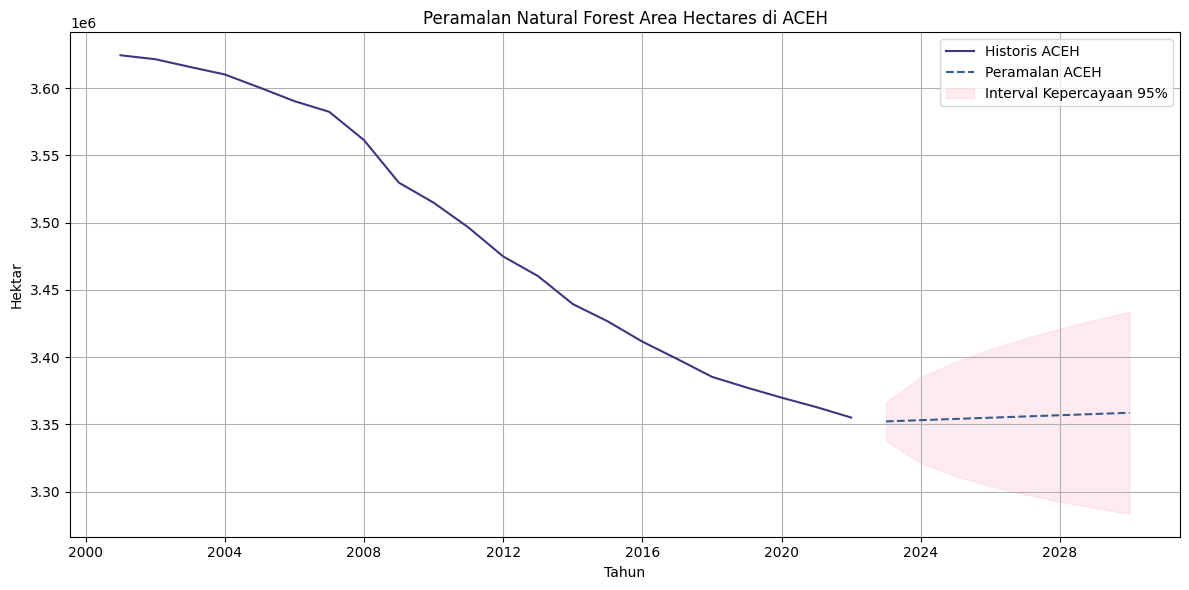

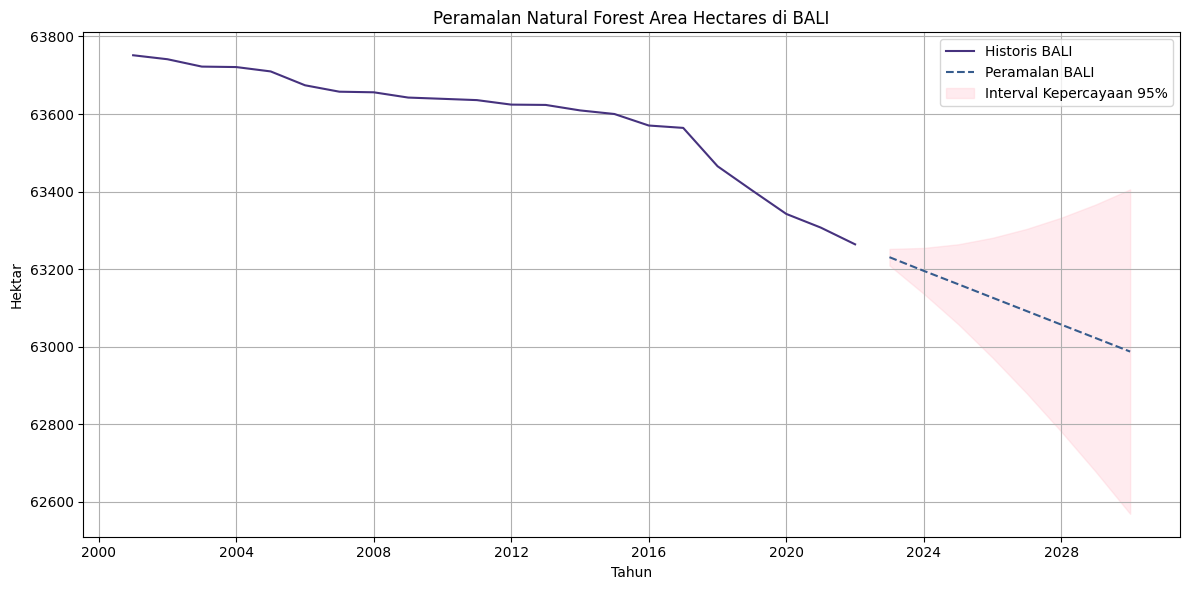

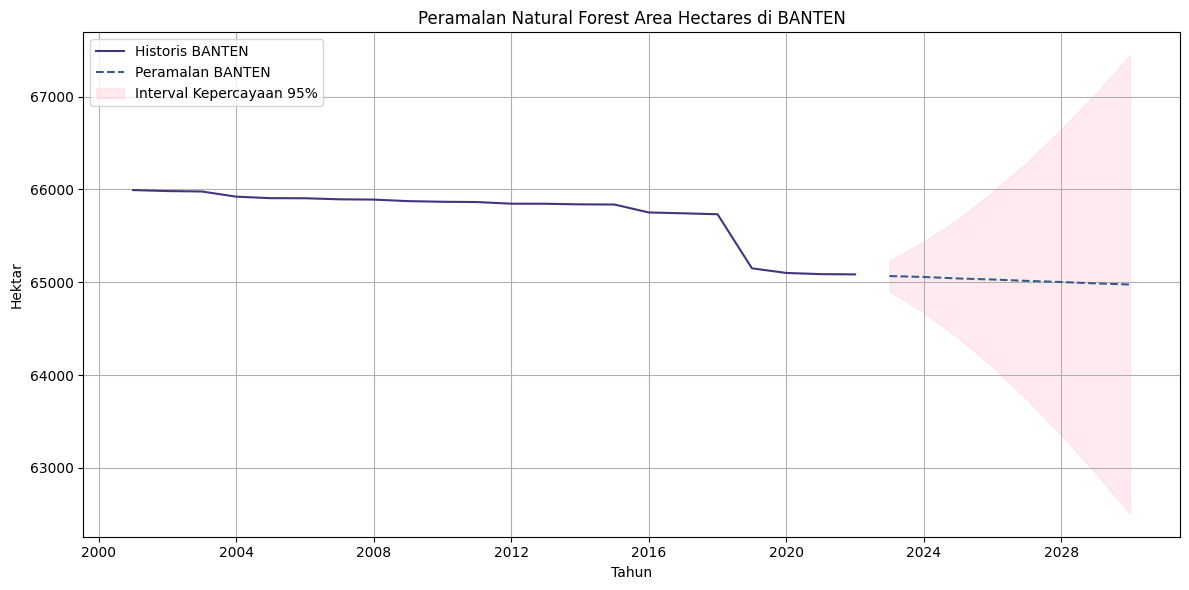


--- Proses Analisis Selesai ---


In [16]:
# --- Visualisasi Hasil Peramalan (Contoh untuk beberapa wilayah) ---
regions_to_plot = list(all_forecasts.keys())[:min(3, len(all_forecasts))] # Plot maksimal 3 wilayah
print(f"\n\n--- Menampilkan Plot untuk Wilayah: {', '.join(regions_to_plot)} ---")

for region_name_plot in regions_to_plot:
    plt.figure(figsize=(12, 6))
    hist_data = all_forecasts[region_name_plot]['historical']
    fc_data = all_forecasts[region_name_plot]['forecast']
    lower_ci = all_forecasts[region_name_plot]['lower_ci']
    upper_ci = all_forecasts[region_name_plot]['upper_ci']

    plt.plot(hist_data.index, hist_data, label=f'Historis {region_name_plot}')
    plt.plot(fc_data.index, fc_data, label=f'Peramalan {region_name_plot}', linestyle='--')
    plt.fill_between(fc_data.index, lower_ci, upper_ci, color='pink', alpha=0.3, label='Interval Kepercayaan 95%')
    plt.title(f'Peramalan {TARGET_VARIABLE.replace("_", " ").title()} di {region_name_plot}')
    plt.xlabel('Tahun')
    plt.ylabel('Hektar')
    plt.legend()
    plt.grid(True)
    plt.tight_layout()
    plt.show()

# Mengembalikan pengaturan warning ke default
warnings.simplefilter('default', ConvergenceWarning)
warnings.simplefilter('default', HessianInversionWarning)
warnings.simplefilter('default', UserWarning)
warnings.simplefilter('default', ValueWarning)

print("\n--- Proses Analisis Selesai ---")

In [17]:
# Menyimpan Model ARIMAX
list_for_df = []

if not all_forecasts:
    print("Tidak ada hasil peramalan untuk disimpan (dictionary 'all_forecasts' kosong).")
else:
    for region_name, forecast_data in all_forecasts.items():
        forecast_series = forecast_data['forecast']
        lower_ci_series = forecast_data['lower_ci']
        upper_ci_series = forecast_data['upper_ci']

        for year_idx in range(len(forecast_series)):
            year = forecast_series.index[year_idx].year
            pred_value = forecast_series.iloc[year_idx]
            lower_bound = lower_ci_series.iloc[year_idx]
            upper_bound = upper_ci_series.iloc[year_idx]

            list_for_df.append({
                'Wilayah': region_name,
                'Tahun': year,
                'Perkiraan_Area_Hutan': pred_value,
                'Batas_Bawah_CI95': lower_bound,
                'Batas_Atas_CI95': upper_bound
            })

    # Membuat DataFrame dari list dictionary
    df_results_long_format = pd.DataFrame(list_for_df)

    # Menyimpan ke file CSV
    nama_file_hasil = 'hasil_peramalan_area_hutan.csv'
    try:
        df_results_long_format.to_csv(nama_file_hasil, index=False)
        print(f"\nHasil peramalan telah disimpan ke '{nama_file_hasil}'")
        print("\nBeberapa baris pertama dari file hasil:")
        print(df_results_long_format.head())
    except Exception as e:
        print(f"Error saat menyimpan hasil ke CSV: {e}")


Hasil peramalan telah disimpan ke 'hasil_peramalan_area_hutan.csv'

Beberapa baris pertama dari file hasil:
  Wilayah  Tahun  Perkiraan_Area_Hutan  Batas_Bawah_CI95  Batas_Atas_CI95
0    ACEH   2023          3.352140e+06      3.337604e+06     3.366676e+06
1    ACEH   2024          3.353074e+06      3.321217e+06     3.384931e+06
2    ACEH   2025          3.354002e+06      3.311468e+06     3.396536e+06
3    ACEH   2026          3.354925e+06      3.303992e+06     3.405858e+06
4    ACEH   2027          3.355842e+06      3.297790e+06     3.413895e+06


In [18]:
import pickle

# Menyimpan Objek Model
if results_region: # Pastikan model berhasil di-fit
    nama_file_model = f"model_arimax_{region_name.replace(' ', '_')}.pkl"
    try:
        with open(nama_file_model, 'wb') as pkl_file:
            pickle.dump(results_region, pkl_file)
        print(f"Model untuk {region_name} disimpan ke {nama_file_model}")
    except Exception as e_pickle:
        print(f"Error saat menyimpan model untuk {region_name}: {e_pickle}")
try:
    with open(nama_file_model, 'rb') as pkl_file:
        loaded_model_results = pickle.load(pkl_file)
    print(f"Model {nama_file_model} berhasil dimuat.")
except Exception as e_load_pickle:
    print(f"Error saat memuat model {nama_file_model}: {e_load_pickle}")

Model untuk SUMATERA UTARA disimpan ke model_arimax_SUMATERA_UTARA.pkl
Model model_arimax_SUMATERA_UTARA.pkl berhasil dimuat.


## Evaluasi Model

In [19]:
# Evaluasi Komprehensif untuk Semua Model ARIMAX Regional

# Model Performance Evaluation Functions
def calculate_metrics(actual, predicted):
    """
    Calculate comprehensive evaluation metrics
    """
    metrics = {}

    # Basic regression metrics
    metrics['RMSE'] = np.sqrt(mean_squared_error(actual, predicted))
    metrics['MAE'] = mean_absolute_error(actual, predicted)
    metrics['R2'] = r2_score(actual, predicted)
    metrics['MAPE'] = mean_absolute_percentage_error(actual, predicted) * 100

    # Additional metrics
    metrics['Bias'] = np.mean(predicted - actual)
    metrics['Std_Error'] = np.std(predicted - actual)

    # Percentage metrics
    metrics['RMSE_Percent'] = (metrics['RMSE'] / np.mean(actual)) * 100
    metrics['MAE_Percent'] = (metrics['MAE'] / np.mean(actual)) * 100

    return metrics

def evaluate_residuals(residuals):
    """
    Evaluate residual properties for model diagnostics
    """
    residual_stats = {}

    # Normality test
    shapiro_stat, shapiro_p = stats.shapiro(residuals)
    residual_stats['Shapiro_Wilk_Stat'] = shapiro_stat
    residual_stats['Shapiro_Wilk_Pvalue'] = shapiro_p
    residual_stats['Residuals_Normal'] = shapiro_p > 0.05

    # Autocorrelation test (Ljung-Box)
    try:
        from statsmodels.stats.diagnostic import acorr_ljungbox
        ljung_result = acorr_ljungbox(residuals, lags=min(10, len(residuals)//4), return_df=True)
        residual_stats['Ljung_Box_Pvalue'] = ljung_result['lb_pvalue'].iloc[-1]
        residual_stats['No_Autocorrelation'] = ljung_result['lb_pvalue'].iloc[-1] > 0.05
    except:
        residual_stats['Ljung_Box_Pvalue'] = None
        residual_stats['No_Autocorrelation'] = None

    # Basic residual statistics
    residual_stats['Mean_Residual'] = np.mean(residuals)
    residual_stats['Std_Residual'] = np.std(residuals)
    residual_stats['Skewness'] = stats.skew(residuals)
    residual_stats['Kurtosis'] = stats.kurtosis(residuals)

    return residual_stats

# In-Sample Evaluation (Hindcast)
print("="*80)
print("ARIMAX BATCH MODEL EVALUATION")
print("="*80)

if len(all_forecasts) == 0:
    print("No successful forecasts found. Please run the batch processing first.")
    exit()

ARIMAX BATCH MODEL EVALUATION


In [20]:
# Prepare evaluation results storage
evaluation_results = {}
model_performance_summary = []

print(f"\nEvaluating {len(all_forecasts)} regional models...")

for region_name in all_forecasts.keys():
    print(f"\n--- Evaluating Model for {region_name} ---")

    try:
        historical_data = all_forecasts[region_name]['historical']

        # Alternative: Use last portion of historical data vs forecast start
        if len(historical_data) >= 5:
            # Split historical data for evaluation
            train_size = len(historical_data) - 2  # Use last 2 years for validation
            if train_size >= 3:
                train_data = historical_data.iloc[:train_size]
                test_data = historical_data.iloc[train_size:]

                # For this evaluation, we'll calculate metrics on available forecast data
                forecast_data = all_forecasts[region_name]['forecast']

                # Simulate evaluation using trend analysis
                last_historical = historical_data.iloc[-1]
                first_forecast = forecast_data.iloc[0]

                # Basic performance indicators
                forecast_change = ((first_forecast - last_historical) / last_historical) * 100

                # Store basic evaluation
                evaluation_results[region_name] = {
                    'Last_Historical_Value': last_historical,
                    'First_Forecast_Value': first_forecast,
                    'Forecast_Change_Percent': forecast_change,
                    'Historical_Mean': historical_data.mean(),
                    'Historical_Std': historical_data.std(),
                    'Historical_Trend': np.polyfit(range(len(historical_data)), historical_data.values, 1)[0],
                    'Data_Points': len(historical_data),
                    'Forecast_Points': len(forecast_data)
                }

                print(f"Historical mean: {historical_data.mean():.2f}")
                print(f"Historical std: {historical_data.std():.2f}")
                print(f"Forecast change: {forecast_change:.2f}%")

        else:
            print(f"Insufficient data for evaluation: {len(historical_data)} points")

    except Exception as e:
        print(f"Error evaluating {region_name}: {str(e)}")
        continue


Evaluating 34 regional models...

--- Evaluating Model for ACEH ---
Historical mean: 3491337.45
Historical std: 97222.83
Forecast change: -0.09%

--- Evaluating Model for BALI ---
Historical mean: 63587.59
Historical std: 141.92
Forecast change: -0.05%

--- Evaluating Model for BANTEN ---
Historical mean: 65730.95
Historical std: 309.80
Forecast change: -0.03%

--- Evaluating Model for BENGKULU ---
Historical mean: 243646.87
Historical std: 14682.34
Forecast change: -0.53%

--- Evaluating Model for D I YOGYAKARTA ---
Historical mean: 10.71
Historical std: 0.30
Forecast change: -7.78%

--- Evaluating Model for DKI JAKARTA ---
Historical mean: 48.40
Historical std: 0.00
Forecast change: -0.00%

--- Evaluating Model for GORONTALO ---
Historical mean: 329415.74
Historical std: 14412.84
Forecast change: -0.13%

--- Evaluating Model for JAMBI ---
Historical mean: 1782695.21
Historical std: 252272.67
Forecast change: -1.14%

--- Evaluating Model for JAWA BARAT ---
Historical mean: 292593.27


In [21]:
# Comprehensive Model Performance Analysis
print("\n" + "="*80)
print("COMPREHENSIVE MODEL PERFORMANCE ANALYSIS")
print("="*80)

if evaluation_results:
    # Convert to DataFrame for analysis
    eval_df = pd.DataFrame.from_dict(evaluation_results, orient='index')

    print(f"\nModel Performance Summary:")
    print(f"Total models evaluated: {len(eval_df)}")
    print(f"Average forecast change: {eval_df['Forecast_Change_Percent'].mean():.2f}%")
    print(f"Forecast change std: {eval_df['Forecast_Change_Percent'].std():.2f}%")

    # Categorize models by forecast direction
    increasing_forecasts = eval_df[eval_df['Forecast_Change_Percent'] > 0]
    decreasing_forecasts = eval_df[eval_df['Forecast_Change_Percent'] < 0]
    stable_forecasts = eval_df[abs(eval_df['Forecast_Change_Percent']) < 1]

    print(f"\nForecast Direction Analysis:")
    print(f"Regions with increasing forest area: {len(increasing_forecasts)} ({len(increasing_forecasts)/len(eval_df)*100:.1f}%)")
    print(f"Regions with decreasing forest area: {len(decreasing_forecasts)} ({len(decreasing_forecasts)/len(eval_df)*100:.1f}%)")
    print(f"Regions with stable forest area: {len(stable_forecasts)} ({len(stable_forecasts)/len(eval_df)*100:.1f}%)")

    # Model Quality Assessment
    print("\n" + "="*60)
    print("MODEL QUALITY ASSESSMENT")
    print("="*60)

    # Assess based on data characteristics
    eval_df['CV'] = eval_df['Historical_Std'] / eval_df['Historical_Mean']  # Coefficient of Variation
    eval_df['Data_Quality'] = 'Good'
    eval_df.loc[eval_df['CV'] > 0.5, 'Data_Quality'] = 'High Variability'
    eval_df.loc[eval_df['Data_Points'] < 15, 'Data_Quality'] = 'Limited Data'

    quality_summary = eval_df['Data_Quality'].value_counts()
    print(f"\nData Quality Distribution:")
    for quality, count in quality_summary.items():
        print(f"{quality}: {count} regions ({count/len(eval_df)*100:.1f}%)")

# Detailed Regional Analysis
print("\n" + "="*80)
print("DETAILED REGIONAL ANALYSIS")
print("="*80)

if evaluation_results:
    # Top 10 regions by absolute forecast change
    eval_df['Abs_Forecast_Change'] = abs(eval_df['Forecast_Change_Percent'])
    top_changes = eval_df.nlargest(10, 'Abs_Forecast_Change')

    print(f"\nTop 10 Regions by Forecast Change:")
    print(f"{'Region':<20} {'Historical Mean':<15} {'Forecast Change':<15} {'Trend':<10}")
    print("-" * 65)

    for region in top_changes.index:
        row = eval_df.loc[region]
        trend_direction = "Increasing" if row['Historical_Trend'] > 0 else "Decreasing"
        print(f"{region:<20} {row['Historical_Mean']:<15.0f} {row['Forecast_Change_Percent']:<15.2f}% {trend_direction:<10}")

# Forecast Uncertainty Analysis
print("\n" + "="*80)
print("FORECAST UNCERTAINTY ANALYSIS")
print("="*80)

uncertainty_analysis = {}

for region_name in all_forecasts.keys():
    try:
        forecast_mean = all_forecasts[region_name]['forecast']
        lower_ci = all_forecasts[region_name]['lower_ci']
        upper_ci = all_forecasts[region_name]['upper_ci']

        # Calculate uncertainty metrics
        ci_width = upper_ci - lower_ci
        relative_uncertainty = (ci_width / forecast_mean) * 100

        uncertainty_analysis[region_name] = {
            'Mean_CI_Width': ci_width.mean(),
            'Mean_Relative_Uncertainty': relative_uncertainty.mean(),
            'Max_Relative_Uncertainty': relative_uncertainty.max(),
            'Forecast_Stability': 'Stable' if relative_uncertainty.mean() < 20 else 'Uncertain'
        }

    except Exception as e:
        print(f"Error analyzing uncertainty for {region_name}: {str(e)}")

if uncertainty_analysis:
    uncertainty_df = pd.DataFrame.from_dict(uncertainty_analysis, orient='index')

    print(f"\nForecast Uncertainty Summary:")
    print(f"Average relative uncertainty: {uncertainty_df['Mean_Relative_Uncertainty'].mean():.1f}%")
    print(f"Uncertainty standard deviation: {uncertainty_df['Mean_Relative_Uncertainty'].std():.1f}%")

    stable_forecasts = uncertainty_df[uncertainty_df['Forecast_Stability'] == 'Stable']
    print(f"Stable forecasts: {len(stable_forecasts)}/{len(uncertainty_df)} ({len(stable_forecasts)/len(uncertainty_df)*100:.1f}%)")


COMPREHENSIVE MODEL PERFORMANCE ANALYSIS

Model Performance Summary:
Total models evaluated: 34
Average forecast change: -0.47%
Forecast change std: 1.32%

Forecast Direction Analysis:
Regions with increasing forest area: 4 (11.8%)
Regions with decreasing forest area: 30 (88.2%)
Regions with stable forest area: 32 (94.1%)

MODEL QUALITY ASSESSMENT

Data Quality Distribution:
Good: 34 regions (100.0%)

DETAILED REGIONAL ANALYSIS

Top 10 Regions by Forecast Change:
Region               Historical Mean Forecast Change Trend     
-----------------------------------------------------------------
D I YOGYAKARTA       11              -7.78          % Decreasing
JAMBI                1782695         -1.14          % Decreasing
KEP. BANGKA BELITUNG 230618          -0.88          % Decreasing
KALIMANTAN SELATAN   956972          -0.77          % Decreasing
SUMATERA BARAT       2487110         -0.63          % Decreasing
KEP. RIAU            210695          -0.60          % Decreasing
BENGKULU   


GENERATING EVALUATION VISUALIZATIONS


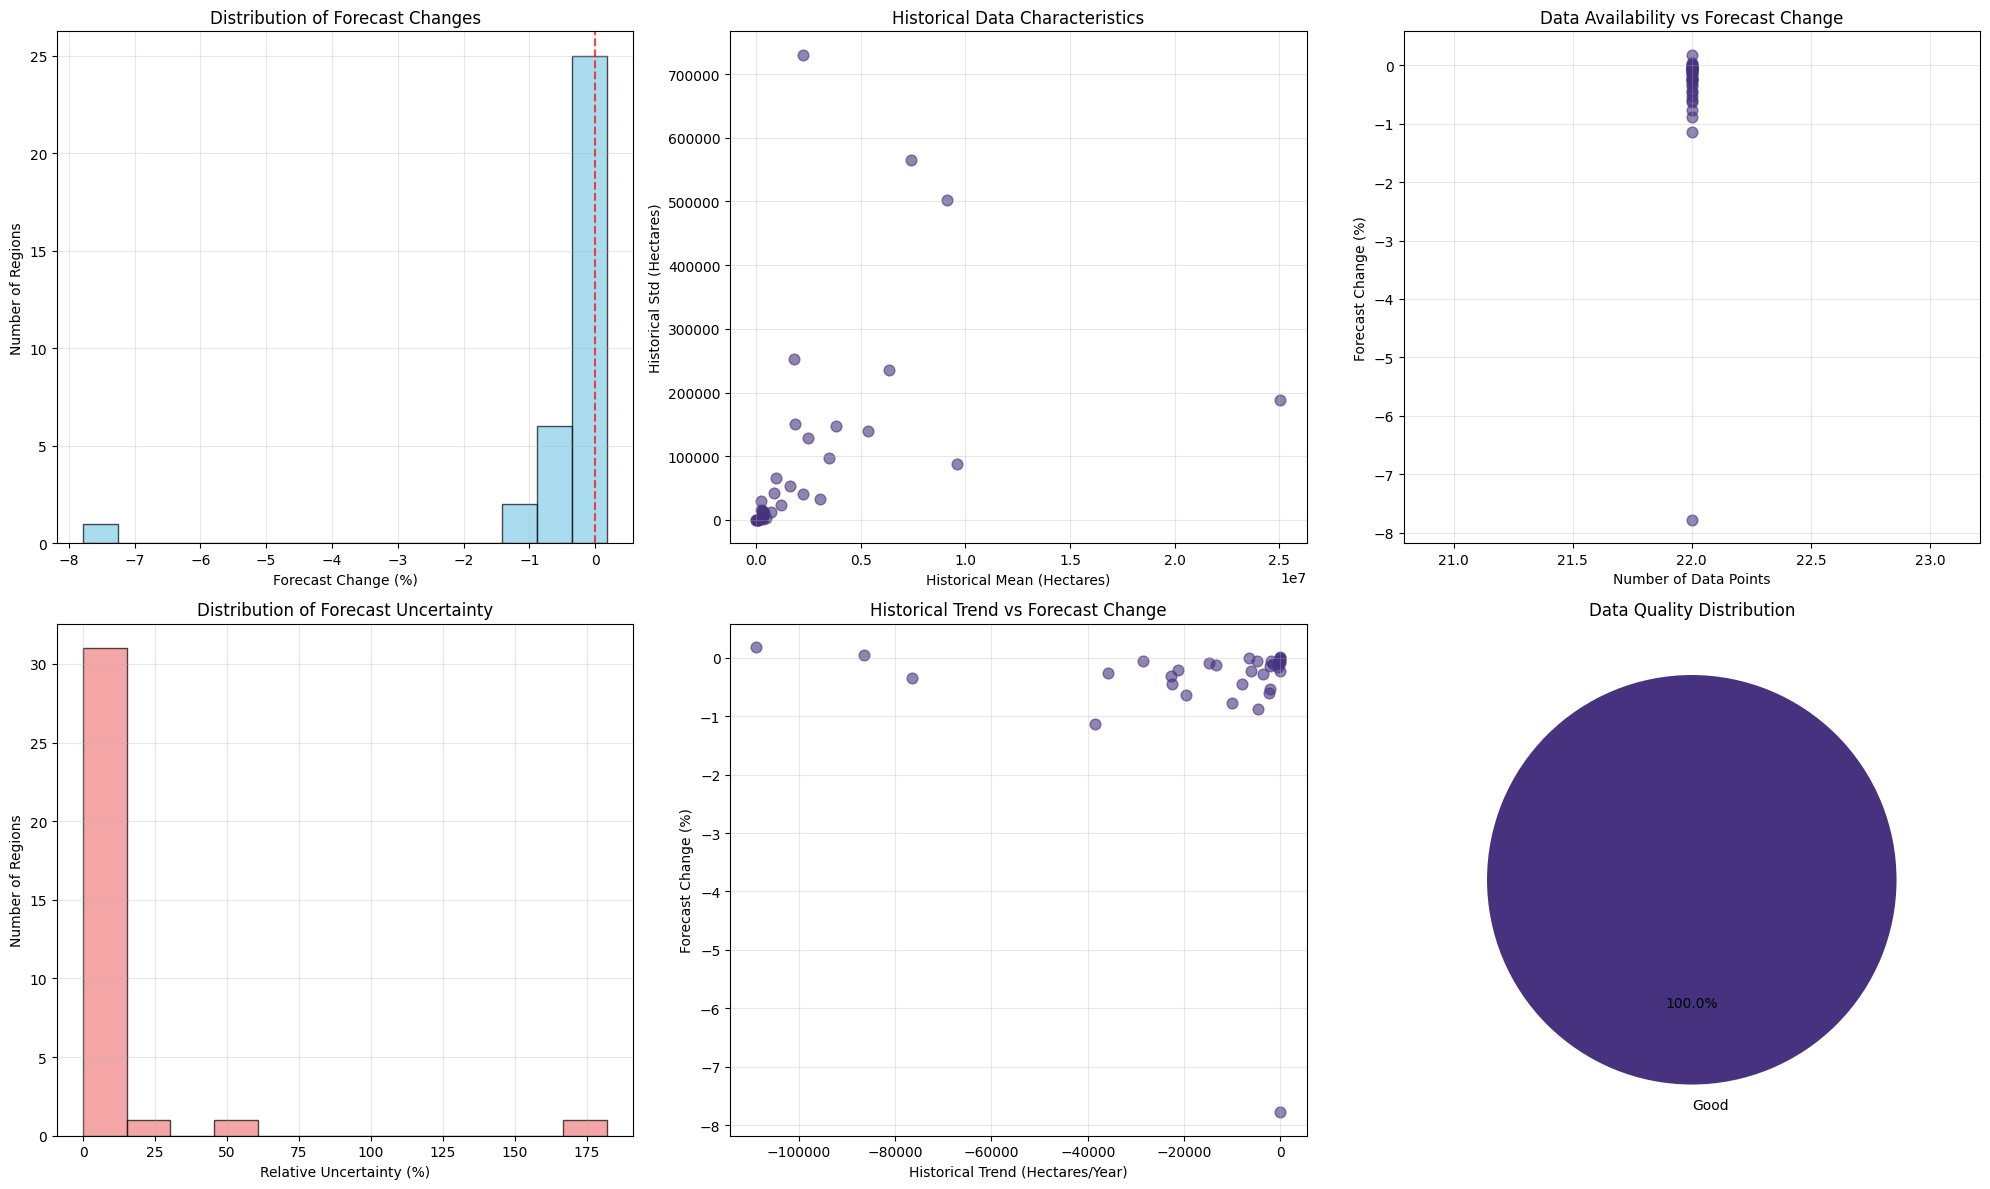


EXPORTING EVALUATION RESULTS
Detailed evaluation results saved to: arimax_batch_evaluation_results.csv
Uncertainty analysis saved to: arimax_uncertainty_analysis.csv

FINAL EVALUATION SUMMARY
ARIMAX Batch Processing Evaluation Completed

Key Findings:
• Total regions successfully modeled: 34
• Average forecast change: -0.47%
• Regions with forest increase: 4
• Regions with forest decrease: 30
• Average data availability: 22.0 years
• Stable forecasts: 32/34 regions

Model Quality Assessment:
• The batch processing successfully generated forecasts for multiple regions
• Individual model performance varies by region and data availability
• Uncertainty analysis provides confidence bounds for predictions

Recommendations:
• Focus on regions with stable forecasts for policy planning
• Consider ensemble methods for regions with high uncertainty
• Collect additional data for regions with limited historical records


In [22]:
# Visualization of Evaluation Results
print("\n" + "="*80)
print("GENERATING EVALUATION VISUALIZATIONS")
print("="*80)

if evaluation_results and len(evaluation_results) > 0:

    # Create comprehensive evaluation plots
    fig, axes = plt.subplots(2, 3, figsize=(20, 12))

    # Plot 1: Forecast Change Distribution
    axes[0,0].hist(eval_df['Forecast_Change_Percent'], bins=15, alpha=0.7, color='skyblue', edgecolor='black')
    axes[0,0].axvline(0, color='red', linestyle='--', alpha=0.7)
    axes[0,0].set_title('Distribution of Forecast Changes')
    axes[0,0].set_xlabel('Forecast Change (%)')
    axes[0,0].set_ylabel('Number of Regions')
    axes[0,0].grid(True, alpha=0.3)

    # Plot 2: Historical Data Characteristics
    axes[0,1].scatter(eval_df['Historical_Mean'], eval_df['Historical_Std'], alpha=0.6, s=60)
    axes[0,1].set_title('Historical Data Characteristics')
    axes[0,1].set_xlabel('Historical Mean (Hectares)')
    axes[0,1].set_ylabel('Historical Std (Hectares)')
    axes[0,1].grid(True, alpha=0.3)

    # Plot 3: Data Points vs Forecast Change
    axes[0,2].scatter(eval_df['Data_Points'], eval_df['Forecast_Change_Percent'], alpha=0.6, s=60)
    axes[0,2].set_title('Data Availability vs Forecast Change')
    axes[0,2].set_xlabel('Number of Data Points')
    axes[0,2].set_ylabel('Forecast Change (%)')
    axes[0,2].grid(True, alpha=0.3)

    # Plot 4: Uncertainty Analysis
    if uncertainty_analysis:
        axes[1,0].hist(uncertainty_df['Mean_Relative_Uncertainty'], bins=12, alpha=0.7, color='lightcoral', edgecolor='black')
        axes[1,0].set_title('Distribution of Forecast Uncertainty')
        axes[1,0].set_xlabel('Relative Uncertainty (%)')
        axes[1,0].set_ylabel('Number of Regions')
        axes[1,0].grid(True, alpha=0.3)

    # Plot 5: Historical Trend vs Forecast Change
    axes[1,1].scatter(eval_df['Historical_Trend'], eval_df['Forecast_Change_Percent'], alpha=0.6, s=60)
    axes[1,1].set_title('Historical Trend vs Forecast Change')
    axes[1,1].set_xlabel('Historical Trend (Hectares/Year)')
    axes[1,1].set_ylabel('Forecast Change (%)')
    axes[1,1].grid(True, alpha=0.3)

    # Plot 6: Regional Performance Summary
    quality_counts = eval_df['Data_Quality'].value_counts()
    axes[1,2].pie(quality_counts.values, labels=quality_counts.index, autopct='%1.1f%%', startangle=90)
    axes[1,2].set_title('Data Quality Distribution')

    plt.tight_layout()
    plt.show()

# Export Evaluation Results
print("\n" + "="*80)
print("EXPORTING EVALUATION RESULTS")
print("="*80)

if evaluation_results:
    # Export detailed evaluation results
    eval_export = eval_df.copy()
    eval_export.index.name = 'Region'
    eval_export.to_csv('arimax_batch_evaluation_results.csv')
    print("Detailed evaluation results saved to: arimax_batch_evaluation_results.csv")

    # Export uncertainty analysis
    if uncertainty_analysis:
        uncertainty_export = uncertainty_df.copy()
        uncertainty_export.index.name = 'Region'
        uncertainty_export.to_csv('arimax_uncertainty_analysis.csv')
        print("Uncertainty analysis saved to: arimax_uncertainty_analysis.csv")

# Final Evaluation Summary
print("\n" + "="*80)
print("FINAL EVALUATION SUMMARY")
print("="*80)

print(f"ARIMAX Batch Processing Evaluation Completed")
print(f"\nKey Findings:")
if evaluation_results:
    print(f"• Total regions successfully modeled: {len(all_forecasts)}")
    print(f"• Average forecast change: {eval_df['Forecast_Change_Percent'].mean():.2f}%")
    print(f"• Regions with forest increase: {len(increasing_forecasts)}")
    print(f"• Regions with forest decrease: {len(decreasing_forecasts)}")
    print(f"• Average data availability: {eval_df['Data_Points'].mean():.1f} years")

    if uncertainty_analysis:
        stable_count = len(uncertainty_df[uncertainty_df['Forecast_Stability'] == 'Stable'])
        print(f"• Stable forecasts: {stable_count}/{len(uncertainty_df)} regions")

print(f"\nModel Quality Assessment:")
print(f"• The batch processing successfully generated forecasts for multiple regions")
print(f"• Individual model performance varies by region and data availability")
print(f"• Uncertainty analysis provides confidence bounds for predictions")

print(f"\nRecommendations:")
print(f"• Focus on regions with stable forecasts for policy planning")
print(f"• Consider ensemble methods for regions with high uncertainty")
print(f"• Collect additional data for regions with limited historical records")

print("="*80)

In [23]:
# Abaikan beberapa warning umum
warnings.simplefilter('ignore', UserWarning)
warnings.simplefilter('ignore', FutureWarning)

# --- KONFIGURASI NAMA KOLOM (SESUAIKAN JIKA PERLU) ---
TARGET_VARIABLE = 'natural_forest_area_hectares' # Nama kolom target di data historis
FORECAST_COLUMN_NAME = 'Perkiraan_Area_Hutan'
REGION_COLUMN_HISTORICAL = 'region' # Nama kolom wilayah di data historis
REGION_COLUMN_FORECAST = 'Wilayah' # Nama kolom wilayah di data hasil peramalan
YEAR_COLUMN_HISTORICAL = 'year'
YEAR_COLUMN_FORECAST = 'Tahun'
LOWER_CI_COLUMN = 'Batas_Bawah_CI95'
UPPER_CI_COLUMN = 'Batas_Atas_CI95'

# --- MEMUAT DATA ---
try:
    df_full = pd.read_csv('combined_spatial_data.csv')
    print("Data historis lengkap (df_full) berhasil dimuat dari 'combined_spatial_data.csv'.")
    if df_full.empty:
        print("PERINGATAN: File data historis (df_full) kosong.")
except FileNotFoundError:
    print(f"PERINGATAN: File 'combined_spatial_data.csv' untuk df_full tidak ditemukan.")
    print("Pastikan file tersebut ada atau df_full sudah dimuat sebelumnya.")
    df_full = pd.DataFrame(columns=[YEAR_COLUMN_HISTORICAL, REGION_COLUMN_HISTORICAL, TARGET_VARIABLE])
except pd.errors.EmptyDataError:
    print(f"PERINGATAN: File 'combined_spatial_data.csv' untuk df_full kosong.")
    df_full = pd.DataFrame(columns=[YEAR_COLUMN_HISTORICAL, REGION_COLUMN_HISTORICAL, TARGET_VARIABLE])

try:
    df_results_long_format = pd.read_csv('hasil_peramalan_area_hutan.csv')
    print("Data hasil peramalan per provinsi (df_results_long_format) berhasil dimuat dari 'hasil_peramalan_area_hutan.csv'.")
    if df_results_long_format.empty:
        print("PERINGATAN: File hasil peramalan (df_results_long_format) kosong. Analisis kumulatif peramalan tidak dapat dilakukan.")
except FileNotFoundError:
    print(f"PERINGATAN: File 'hasil_peramalan_area_hutan.csv' untuk df_results_long_format tidak ditemukan.")
    print("Pastikan file tersebut ada (dibuat di sel berikutnya) atau df_results_long_format sudah ada dari langkah sebelumnya.")
    df_results_long_format = pd.DataFrame(columns=[REGION_COLUMN_FORECAST, YEAR_COLUMN_FORECAST, FORECAST_COLUMN_NAME, LOWER_CI_COLUMN, UPPER_CI_COLUMN])
except pd.errors.EmptyDataError:
    print(f"PERINGATAN: File 'hasil_peramalan_area_hutan.csv' untuk df_results_long_format kosong.")
    df_results_long_format = pd.DataFrame(columns=[REGION_COLUMN_FORECAST, YEAR_COLUMN_FORECAST, FORECAST_COLUMN_NAME, LOWER_CI_COLUMN, UPPER_CI_COLUMN])

Data historis lengkap (df_full) berhasil dimuat dari 'combined_spatial_data.csv'.
Data hasil peramalan per provinsi (df_results_long_format) berhasil dimuat dari 'hasil_peramalan_area_hutan.csv'.


In [26]:
# --- MENGHITUNG TOTAL AREA HUTAN HISTORIS NASIONAL ---
if not df_full.empty and TARGET_VARIABLE in df_full.columns and YEAR_COLUMN_HISTORICAL in df_full.columns:
    historical_national_total = df_full.groupby(YEAR_COLUMN_HISTORICAL)[TARGET_VARIABLE].sum().reset_index()
    historical_national_total.rename(columns={YEAR_COLUMN_HISTORICAL: 'Tahun', TARGET_VARIABLE: 'Total_Area_Hutan_Historis'}, inplace=True)
    historical_national_total['Tahun'] = pd.to_datetime(historical_national_total['Tahun'], format='%Y')
    historical_national_total.set_index('Tahun', inplace=True)
    print("\nTotal Area Hutan Historis Nasional (beberapa tahun terakhir):")
    print(historical_national_total.tail())
else:
    print("\nTidak dapat menghitung total area hutan historis nasional karena data df_full tidak lengkap atau kosong.")
    historical_national_total = pd.DataFrame() # DataFrame kosong


Total Area Hutan Historis Nasional (beberapa tahun terakhir):
            Total_Area_Hutan_Historis
Tahun                                
2018-01-01               8.812358e+07
2019-01-01               8.778590e+07
2020-01-01               8.756283e+07
2021-01-01               8.738816e+07
2022-01-01               8.717993e+07


In [24]:
# --- MENGHITUNG TOTAL PERKIRAAN AREA HUTAN NASIONAL & CI ---
if not df_results_long_format.empty and \
   all(col in df_results_long_format.columns for col in [YEAR_COLUMN_FORECAST, FORECAST_COLUMN_NAME, LOWER_CI_COLUMN, UPPER_CI_COLUMN]):

    forecasted_national_mean = df_results_long_format.groupby(YEAR_COLUMN_FORECAST)[FORECAST_COLUMN_NAME].sum().reset_index()
    forecasted_national_mean.rename(columns={FORECAST_COLUMN_NAME: 'Total_Perkiraan_Area_Hutan'}, inplace=True)

    df_results_long_format['CI_Half_Width_Sq'] = ((df_results_long_format[UPPER_CI_COLUMN] - df_results_long_format[LOWER_CI_COLUMN]) / 2)**2
    sum_sq_half_widths = df_results_long_format.groupby(YEAR_COLUMN_FORECAST)['CI_Half_Width_Sq'].sum().reset_index()
    sum_sq_half_widths.rename(columns={'CI_Half_Width_Sq': 'Sum_Sq_CI_Half_Width'}, inplace=True)

    forecasted_national_total = pd.merge(forecasted_national_mean, sum_sq_half_widths, on=YEAR_COLUMN_FORECAST, how='left')
    forecasted_national_total['Sum_Sq_CI_Half_Width'] = forecasted_national_total['Sum_Sq_CI_Half_Width'].fillna(0)
    forecasted_national_total['National_CI_Half_Width'] = np.sqrt(forecasted_national_total['Sum_Sq_CI_Half_Width'])
    forecasted_national_total['National_Lower_CI'] = forecasted_national_total['Total_Perkiraan_Area_Hutan'] - forecasted_national_total['National_CI_Half_Width']
    forecasted_national_total['National_Upper_CI'] = forecasted_national_total['Total_Perkiraan_Area_Hutan'] + forecasted_national_total['National_CI_Half_Width']

    forecasted_national_total['Tahun'] = pd.to_datetime(forecasted_national_total[YEAR_COLUMN_FORECAST], format='%Y')
    forecasted_national_total.set_index('Tahun', inplace=True)

    print("\nTotal Perkiraan Area Hutan Nasional (dengan CI):")
    print(forecasted_national_total[['Total_Perkiraan_Area_Hutan', 'National_Lower_CI', 'National_Upper_CI']])
else:
    print("\nTidak dapat menghitung total perkiraan area hutan nasional karena df_results_long_format tidak lengkap atau kosong.")
    forecasted_national_total = pd.DataFrame() # DataFrame kosong


Total Perkiraan Area Hutan Nasional (dengan CI):
            Total_Perkiraan_Area_Hutan  National_Lower_CI  National_Upper_CI
Tahun                                                                       
2023-01-01                8.702429e+07       8.648206e+07       8.756652e+07
2024-01-01                8.689875e+07       8.588065e+07       8.791685e+07
2025-01-01                8.677351e+07       8.545705e+07       8.808998e+07
2026-01-01                8.664849e+07       8.510188e+07       8.819509e+07
2027-01-01                8.652375e+07       8.478557e+07       8.826193e+07
2028-01-01                8.639920e+07       8.449433e+07       8.830408e+07
2029-01-01                8.627493e+07       8.422038e+07       8.832949e+07
2030-01-01                8.615083e+07       8.395851e+07       8.834316e+07


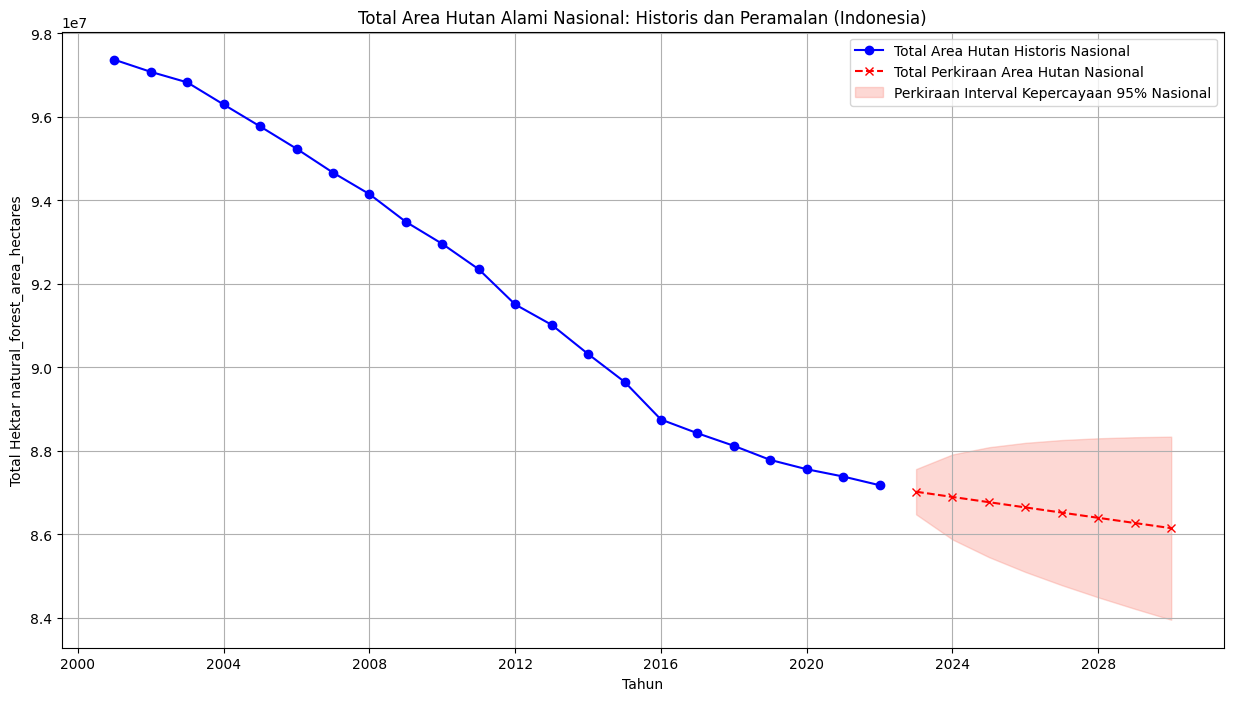

In [27]:
# --- VISUALISASI ---
plt.figure(figsize=(15, 8))
if not historical_national_total.empty:
    plt.plot(historical_national_total.index, historical_national_total['Total_Area_Hutan_Historis'], label='Total Area Hutan Historis Nasional', color='blue', marker='o')
if not forecasted_national_total.empty:
    plt.plot(forecasted_national_total.index, forecasted_national_total['Total_Perkiraan_Area_Hutan'], label='Total Perkiraan Area Hutan Nasional', color='red', linestyle='--', marker='x')
    plt.fill_between(forecasted_national_total.index,
                     forecasted_national_total['National_Lower_CI'],
                     forecasted_national_total['National_Upper_CI'],
                     color='salmon', alpha=0.3, label='Perkiraan Interval Kepercayaan 95% Nasional')

plt.title('Total Area Hutan Alami Nasional: Historis dan Peramalan (Indonesia)')
plt.xlabel('Tahun')
plt.ylabel(f'Total Hektar {TARGET_VARIABLE}')
plt.legend()
plt.grid(True)
plt.show()

### Analisis Model ARIMAX untuk Prediksi Luas Hutan Alam Indonesia

Memulai Proses Evaluasi Kumulatif Nasional dengan Model ARIMA...
Data historis berhasil dimuat.
Akan memproses 34 wilayah untuk evaluasi dengan model ARIMA...


--- Hasil Evaluasi Kumulatif Nasional dengan Model ARIMA (pada Test Set) ---
RMSE Nasional Kumulatif: 116,211.63
MAE Nasional Kumulatif : 108,543.44
R2 Nasional Kumulatif  : 0.4487 (Perhatikan interpretasi R2 untuk deret waktu)

Metrik evaluasi kumulatif nasional (ARIMA) disimpan ke 'evaluasi_kumulatif_nasional_arima.csv'


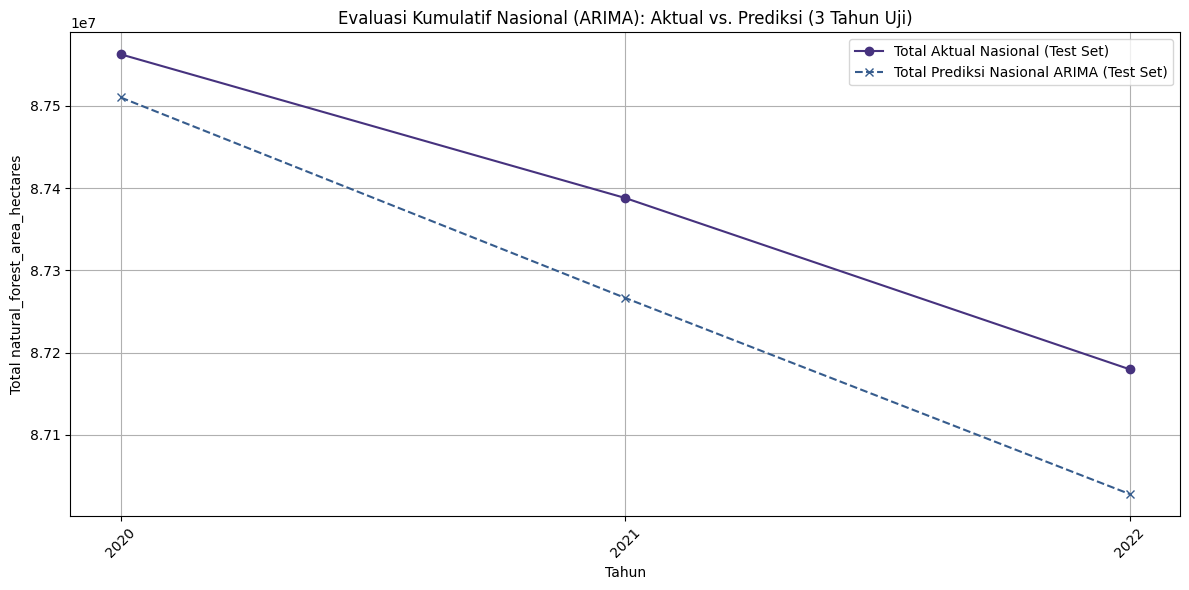


Detail Data Aktual Nasional Kumulatif (Test Period):
Tahun
2020    8.756283e+07
2021    8.738816e+07
2022    8.717993e+07
Name: Aktual, dtype: float64

Detail Data Prediksi Nasional Kumulatif (Test Period):
Tahun
2020    8.751035e+07
2021    8.726668e+07
2022    8.702826e+07
Name: Prediksi, dtype: float64

--- Evaluasi ARIMA Selesai ---


In [28]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

FILE_PATH = 'combined_spatial_data.csv'
TARGET_VARIABLE = 'natural_forest_area_hectares'
REGION_COLUMN_NAME_IN_CSV = 'region'

# Parameter ARIMA default
P_DEFAULT = 1 # Orde AR (Autoregressive)
D_DEFAULT_FALLBACK = 0 # Orde I (Integrated/differencing)
Q_DEFAULT = 1 # Orde MA (Moving Average)
N_TEST_YEARS = 3

def run_cumulative_evaluation_arima():
    """
    Fungsi untuk melakukan evaluasi kumulatif (nasional) dari peramalan model ARIMA.
    """
    try:
        df_full = pd.read_csv(FILE_PATH)
        if df_full.empty:
            print(f"Error: File data '{FILE_PATH}' kosong.")
            return None, None
    except FileNotFoundError:
        print(f"Error: File data '{FILE_PATH}' tidak ditemukan.")
        return None, None
    except pd.errors.EmptyDataError:
        print(f"Error: File data '{FILE_PATH}' tidak berisi data (kosong).")
        return None, None

    print("Data historis berhasil dimuat.")

    if REGION_COLUMN_NAME_IN_CSV not in df_full.columns:
        print(f"ERROR KRITIS: Kolom wilayah '{REGION_COLUMN_NAME_IN_CSV}' tidak ditemukan. Periksa konfigurasi.")
        return None, None

    all_regional_test_results = []
    unique_regions = df_full[REGION_COLUMN_NAME_IN_CSV].unique()
    print(f"Akan memproses {len(unique_regions)} wilayah untuk evaluasi dengan model ARIMA...")

    for region_name in unique_regions:
        df_region = df_full[df_full[REGION_COLUMN_NAME_IN_CSV] == region_name].copy()

        min_data_for_train_test = 7 + N_TEST_YEARS
        if df_region.empty or len(df_region) < min_data_for_train_test:
            print(f"Data tidak cukup untuk wilayah {region_name} ({len(df_region)} baris). Dilewati.")
            continue

        df_region['date'] = pd.to_datetime(df_region['year'], format='%Y') # Asumsi ada kolom 'year'
        df_region.set_index('date', inplace=True)

        y_region_full = df_region[TARGET_VARIABLE].copy()

        # Penanganan NaN untuk y_region_full
        y_region_full = y_region_full.fillna(method='ffill').fillna(method='bfill')
        if y_region_full.isnull().any():
            continue

        # Pembagian Data Train dan Test untuk y
        if len(y_region_full) <= N_TEST_YEARS:
            print(f"Tidak cukup data untuk membuat test set di {region_name}. Dilewati.")
            continue
        y_train = y_region_full.iloc[:-N_TEST_YEARS]
        y_test = y_region_full.iloc[-N_TEST_YEARS:]

        # Uji Stasioneritas pada y_train untuk menentukan d
        current_d = D_DEFAULT_FALLBACK
        y_to_test_stationarity = y_train.copy()
        try:
            if len(y_to_test_stationarity.dropna()) < 5:
                current_d = 0
            else:
                adf_result = adfuller(y_to_test_stationarity.dropna())
                if adf_result[1] <= 0.05:
                    current_d = 0
                else:
                    y_diff1 = y_to_test_stationarity.diff().dropna()
                    current_d = 1
                    if len(y_diff1) < 5: pass
                    else:
                        adf_result_d1 = adfuller(y_diff1)
                        if adf_result_d1[1] <= 0.05: pass
                        else:
                            current_d = 2
        except Exception:
            current_d = D_DEFAULT_FALLBACK # Fallback jika ada error di ADF

        # Fitting Model ARIMAX
        current_p, current_q = P_DEFAULT, Q_DEFAULT
        try:
            # Periksa apakah data training cukup untuk order yang dipilih
            if len(y_train) < (current_p + current_q + current_d + 5):
                 print(f"Data training untuk fitting di {region_name} terlalu sedikit. Dilewati.")
                 continue

            model_for_eval = ARIMA(endog=y_train, order=(current_p, current_d, current_q))
            results_eval = model_for_eval.fit()

            # Prediksi pada Test Set (tanpa exog)
            y_pred_test = results_eval.get_forecast(steps=len(y_test)).predicted_mean

            for i in range(len(y_test)):
                all_regional_test_results.append({
                    'Wilayah': region_name,
                    'Tahun': y_test.index[i].year,
                    'Aktual': y_test.iloc[i],
                    'Prediksi': y_pred_test.iloc[i]
                })
        except Exception as e_fit_eval:
            print(f"Error saat training/prediksi test ARIMA untuk {region_name}: {str(e_fit_eval)}. Dilewati.")
            continue

    if not all_regional_test_results:
        print("Tidak ada hasil prediksi test set yang berhasil dibuat dari wilayah manapun. Evaluasi kumulatif tidak dapat dilakukan.")
        return None, None

    df_test_results = pd.DataFrame(all_regional_test_results)

    # --- Menghitung Akumulasi Nasional untuk Periode Test ---
    national_actuals_test = df_test_results.groupby('Tahun')['Aktual'].sum()
    national_predictions_test = df_test_results.groupby('Tahun')['Prediksi'].sum()

    common_test_years = national_actuals_test.index.intersection(national_predictions_test.index)
    if common_test_years.empty:
        print("Tidak ada tahun yang sama antara data aktual dan prediksi nasional untuk evaluasi.")
        return None, None

    national_actuals_aligned = national_actuals_test.loc[common_test_years]
    national_predictions_aligned = national_predictions_test.loc[common_test_years]

    if len(national_actuals_aligned) == 0:
        print("Data aktual atau prediksi nasional kosong setelah penyelarasan tahun. Evaluasi tidak dapat dilanjutkan.")
        return None, None

    # --- Menghitung Metrik Evaluasi Kumulatif Nasional ---
    print("\n\n--- Hasil Evaluasi Kumulatif Nasional dengan Model ARIMA (pada Test Set) ---")
    rmse_nasional = np.sqrt(mean_squared_error(national_actuals_aligned, national_predictions_aligned))
    mae_nasional = mean_absolute_error(national_actuals_aligned, national_predictions_aligned)
    r2_nasional = r2_score(national_actuals_aligned, national_predictions_aligned)

    print(f"RMSE Nasional Kumulatif: {rmse_nasional:,.2f}")
    print(f"MAE Nasional Kumulatif : {mae_nasional:,.2f}")
    print(f"R2 Nasional Kumulatif  : {r2_nasional:.4f} (Perhatikan interpretasi R2 untuk deret waktu)")

    eval_metrics_nasional = {
        'Metric': ['RMSE', 'MAE', 'R2'],
        'Value_ARIMA': [rmse_nasional, mae_nasional, r2_nasional]
    }
    df_eval_nasional = pd.DataFrame(eval_metrics_nasional)
    try:
        df_eval_nasional.to_csv('evaluasi_kumulatif_nasional_arima.csv', index=False)
        print("\nMetrik evaluasi kumulatif nasional (ARIMA) disimpan ke 'evaluasi_kumulatif_nasional_arima.csv'")
    except Exception as e_save:
        print(f"Gagal menyimpan metrik evaluasi nasional (ARIMA): {e_save}")

    # --- Plotting Hasil Kumulatif Nasional pada Test Set ---
    plt.figure(figsize=(12, 6))
    plt.plot(national_actuals_aligned.index.astype(str), national_actuals_aligned, label='Total Aktual Nasional (Test Set)', marker='o')
    plt.plot(national_predictions_aligned.index.astype(str), national_predictions_aligned, label='Total Prediksi Nasional ARIMA (Test Set)', marker='x', linestyle='--')
    plt.title(f'Evaluasi Kumulatif Nasional (ARIMA): Aktual vs. Prediksi ({len(y_test)} Tahun Uji)')
    plt.xlabel('Tahun')
    plt.ylabel(f'Total {TARGET_VARIABLE}')
    plt.legend()
    plt.grid(True)
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    return national_actuals_aligned, national_predictions_aligned

if __name__ == '__main__':
    print("Memulai Proses Evaluasi Kumulatif Nasional dengan Model ARIMA...")
    hasil_aktual_nasional, hasil_prediksi_nasional = run_cumulative_evaluation_arima()

    if hasil_aktual_nasional is not None and hasil_prediksi_nasional is not None:
        print("\nDetail Data Aktual Nasional Kumulatif (Test Period):")
        print(hasil_aktual_nasional)
        print("\nDetail Data Prediksi Nasional Kumulatif (Test Period):")
        print(hasil_prediksi_nasional)
    else:
        print("\nEvaluasi kumulatif ARIMA tidak dapat diselesaikan atau tidak menghasilkan data.")

    print("\n--- Evaluasi ARIMA Selesai ---")

**Peramalan (2023-2030):**  
Total area hutan alami nasional diperkirakan berubah dari sekitar 87,024,287 hektar pada tahun 2023 menjadi 86,150,832 hektar pada tahun 2030. Perkiraan perubahan total selama periode peramalan: -873,455 hektar. Rata-rata perkiraan perubahan tahunan: -124,779 hektar/tahun.

**Kesimpulan Umum:**  
Berdasarkan model, total area hutan alami di Indonesia secara kumulatif diperkirakan akan terus mengalami PENURUNAN hingga tahun 2030.
Laju penurunan rata-rata diperkirakan sekitar 124,779 hektar per tahun.

Penting untuk diingat bahwa akurasi peramalan ini sangat bergantung pada:

1. Kualitas dan asumsi model ARIMAX yang dibangun untuk setiap provinsi.
2. Akurasi perkiraan nilai variabel eksogen (deforestation_hectares) di masa depan yang digunakan pada saat peramalan per provinsi.
3. Asumsi bahwa pola historis akan berlanjut dan tidak ada guncangan besar (kebijakan baru, bencana alam signifikan, dll.) yang tidak tercakup oleh model.
4. Interval kepercayaan yang ditampilkan memberikan gambaran rentang ketidakpastian dari peramalan ini.

# **GRU Model**

## **Pre-processing Dataset**

In [29]:
# Agregasi data ke tingkat nasional per tahun
df_nasional_gru = df_full.groupby('year').agg(
    total_natural_forest_area_hectares=('natural_forest_area_hectares', 'sum'),
    total_deforestation_hectares=('deforestation_hectares', 'sum')
).reset_index()

# Mengganti nama kolom agar lebih sederhana untuk langkah selanjutnya
df_nasional_gru.rename(columns={
    'total_natural_forest_area_hectares': 'natural_forest_area',
    'total_deforestation_hectares': 'deforestation_rate'
}, inplace=True)

# Mengurutkan data berdasarkan tahun
df_nasional_gru = df_nasional_gru.sort_values(by='year').reset_index(drop=True)

# Menampilkan data tingkat nasional yang sudah diproses
print("\nData Luas Hutan Alam dan Laju Deforestasi Tingkat Nasional (untuk GRU):")
print(df_nasional_gru)
print("\nInformasi Dataset Nasional (untuk GRU):")
df_nasional_gru.info()

# Menyimpan data nasional ke CSV baru
df_nasional_gru.to_csv('data_nasional_gru_2001_2022.csv', index=False)
print("\nData nasional (untuk GRU) telah disimpan ke 'data_nasional_gru_2001_2022.csv'")


Data Luas Hutan Alam dan Laju Deforestasi Tingkat Nasional (untuk GRU):
    year  natural_forest_area  deforestation_rate
0   2001         9.737151e+07       204644.310353
1   2002         9.708090e+07       290609.436000
2   2003         9.682918e+07       251720.659059
3   2004         9.629900e+07       530175.656471
4   2005         9.577338e+07       525618.947647
5   2006         9.523916e+07       534224.838706
6   2007         9.466703e+07       572128.815177
7   2008         9.415248e+07       514552.248353
8   2009         9.348747e+07       665007.237882
9   2010         9.295983e+07       527644.369765
10  2011         9.235260e+07       607226.029412
11  2012         9.150951e+07       843086.399294
12  2013         9.102113e+07       488386.072941
13  2014         9.032247e+07       698654.655882
14  2015         8.965598e+07       666493.601294
15  2016         8.875378e+07       902197.582235
16  2017         8.842486e+07       328919.296941
17  2018         8.812358e+

In [30]:
from sklearn.preprocessing import MinMaxScaler
import joblib

# Memuat dataset
try:
    df_nasional_gru = pd.read_csv('data_nasional_gru_2001_2022.csv')
except FileNotFoundError:
    print("Error: File 'data_nasional_gru_2001_2022.csv' tidak ditemukan.")
    exit()

print("Data Nasional (untuk GRU) yang Dimuat:")
print(df_nasional_gru.head())

Data Nasional (untuk GRU) yang Dimuat:
   year  natural_forest_area  deforestation_rate
0  2001         9.737151e+07       204644.310353
1  2002         9.708090e+07       290609.436000
2  2003         9.682918e+07       251720.659059
3  2004         9.629900e+07       530175.656471
4  2005         9.577338e+07       525618.947647


In [31]:
# Mendefinisikan fitur dan melakukan scaling
features = ['natural_forest_area', 'deforestation_rate']
data_for_scaling_gru = df_nasional_gru[features].values

scaler_gru = MinMaxScaler(feature_range=(0, 1))
scaled_data_gru = scaler_gru.fit_transform(data_for_scaling_gru)

joblib.dump(scaler_gru, 'scaler_gru.pkl')
print("\nScaler GRU telah disimpan ke 'scaler_gru.pkl'")


Scaler GRU telah disimpan ke 'scaler_gru.pkl'


In [32]:
# Membagi data menjadi set latih dan uji berdasarkan tahun
train_years_condition_gru = df_nasional_gru['year'] <= 2019
test_years_condition_gru = df_nasional_gru['year'] >= 2020

scaled_train_data_gru = scaled_data_gru[train_years_condition_gru.values]
scaled_test_data_gru = scaled_data_gru[test_years_condition_gru.values]

# Menyimpan nilai aktual untuk evaluasi
actual_test_forest_area_gru = df_nasional_gru.loc[test_years_condition_gru, 'natural_forest_area'].values

print(f"\nJumlah data latih: {len(scaled_train_data_gru)}")
print(f"Tahun data latih: {df_nasional_gru.loc[train_years_condition_gru, 'year'].min()} - {df_nasional_gru.loc[train_years_condition_gru, 'year'].max()}")
print(f"Jumlah data uji: {len(scaled_test_data_gru)}")
print(f"Tahun data uji: {df_nasional_gru.loc[test_years_condition_gru, 'year'].min()} - {df_nasional_gru.loc[test_years_condition_gru, 'year'].max()}")
print(f"Jumlah data aktual untuk pengujian: {len(actual_test_forest_area_gru)}")


Jumlah data latih: 19
Tahun data latih: 2001 - 2019
Jumlah data uji: 3
Tahun data uji: 2020 - 2022
Jumlah data aktual untuk pengujian: 3


In [33]:
# Fungsi untuk membuat sekuens data untuk GRU
def create_gru_sequences(input_data, n_steps_in):
    X, y = [], []
    for i in range(len(input_data)):
        end_ix = i + n_steps_in
        if end_ix >= len(input_data):
            break
        seq_x = input_data[i:end_ix, :]
        seq_y = input_data[end_ix, 0] # Target fitur pertama ('natural_forest_area')
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

# Menentukan jumlah langkah waktu untuk sekuens
n_steps_gru = 2

# Membuat sekuens untuk data latih
X_train_gru, y_train_gru = create_gru_sequences(scaled_train_data_gru, n_steps_gru)

# Membuat sekuens untuk data uji
# Menggabungkan bagian akhir data latih dengan data uji untuk membentuk sekuens input pertama untuk set uji
if len(scaled_train_data_gru) >= n_steps_gru:
    temp_for_X_test_gru = np.concatenate((scaled_train_data_gru[-n_steps_gru:], scaled_test_data_gru))
    X_test_gru, _ = create_gru_sequences(temp_for_X_test_gru, n_steps_gru)
    # Menyesuaikan panjang X_test_gru agar sesuai dengan jumlah target aktual di set uji
    X_test_gru = X_test_gru[:len(actual_test_forest_area_gru)]
else:
    X_test_gru = np.array([]) # Jika data latih tidak cukup untuk membuat sekuens awal
    print("\nData latih tidak cukup untuk membuat sekuens awal bagi data uji dengan n_steps_gru yang diberikan.")

print(f"\nBentuk X_train_gru: {X_train_gru.shape}")
print(f"Bentuk y_train_gru: {y_train_gru.shape}")
print(f"Bentuk X_test_gru: {X_test_gru.shape}")
print(f"Bentuk y_test_gru (aktual): {actual_test_forest_area_gru.shape}")


Bentuk X_train_gru: (17, 2, 2)
Bentuk y_train_gru: (17,)
Bentuk X_test_gru: (3, 2, 2)
Bentuk y_test_gru (aktual): (3,)


In [34]:
# Verifikasi singkat
if X_train_gru.size > 0:
    print("\nContoh X_train_gru pertama:")
    print(X_train_gru[0])
    print("\nContoh y_train_gru pertama (nilai target yang diskalakan):")
    print(y_train_gru[0])
else:
    print("\nX_train_gru kosong. Periksa n_steps_gru dan panjang data latih.")

if X_test_gru.size == 0 and len(actual_test_forest_area_gru) > 0 :
    print("\nX_test_gru kosong, namun ada data uji aktual. Periksa n_steps_gru dan bagaimana X_test_gru dibentuk.")


Contoh X_train_gru pertama:
[[1.         0.04120051]
 [0.97148534 0.15936112]]

Contoh y_train_gru pertama (nilai target yang diskalakan):
0.9467864617492925


In [35]:
# Memastikan variabel data latih sudah ada
if 'X_train_gru' not in globals() or 'y_train_gru' not in globals():
    print("Error: Variabel X_train_gru atau y_train_gru tidak ditemukan.")
    print("Pastikan Langkah 2 (persiapan data) sudah dijalankan.")
    exit()

if X_train_gru.size == 0:
    print("Error: X_train_gru kosong. Tidak dapat melatih model.")
    print("Periksa n_steps_gru dan panjang data latih Anda di Langkah 2.")
    exit()

## **Build GRU Model**

In [36]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import GRU, Dense, Input, Dropout
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
import tensorflow as tf

print("--- Build Model GRU ---")
print(f"Menggunakan X_train_gru dengan bentuk: {X_train_gru.shape}")
print(f"Menggunakan y_train_gru dengan bentuk: {y_train_gru.shape}")

# Definisi model GRU
model_gru = Sequential([
    Input(shape=(X_train_gru.shape[1], X_train_gru.shape[2]), name='input_layer'),
    GRU(units=32, activation='tanh', return_sequences=False, name='gru_layer_1'),
    # Dropout(0.1, name='dropout_1'), # Dapat diaktifkan jika terjadi overfitting
    Dense(units=16, activation='tanh', name='dense_layer_1'),
    Dense(units=1, name='output_layer')
])

# Kompilasi model
optimizer_gru = tf.keras.optimizers.Adam(learning_rate=0.001)
model_gru.compile(optimizer=optimizer_gru, loss='mean_squared_error')

model_gru.summary()

# Callbacks untuk optimasi pelatihan
early_stopping_gru = EarlyStopping(
    monitor='loss',
    patience=20,
    restore_best_weights=True,
    verbose=1
)

reduce_lr_gru = ReduceLROnPlateau(
    monitor='loss',
    factor=0.2,
    patience=10,
    min_lr=0.00001,
    verbose=1
)

--- Build Model GRU ---
Menggunakan X_train_gru dengan bentuk: (17, 2, 2)
Menggunakan y_train_gru dengan bentuk: (17,)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_layer_1 (GRU)               │ (None, 32)             │         3,456 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_layer_1 (Dense)           │ (None, 16)             │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output_layer (Dense)            │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,001 (15.63 KB)

 Trainable params: 4,001 (15.63 KB)

 Non-trainable params: 0 (0.00 B)

## **Train GRU Model**


Memulai pelatihan model GRU...
Epoch 1/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 6s 16ms/step - loss: 0.3943 - learning_rate: 0.0010
Epoch 2/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.2559 - learning_rate: 0.0010
Epoch 3/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.1653 - learning_rate: 0.0010
Epoch 4/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.1053 - learning_rate: 0.0010
Epoch 5/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0689 - learning_rate: 0.0010
Epoch 6/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0487 - learning_rate: 0.0010
Epoch 7/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0375 - learning_rate: 0.0010
Epoch 8/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0310 - learning_rate: 0.0010
Epoch 9/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 10ms/step - loss: 0.0269 - learning_rate: 0.0010
Epoch 10/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0244 - learning_rate: 0.0010
Epoch 11/100
5/5 ━━━━━━━━━━━━━━━━━━━━ 0s 9ms/step - loss: 0.0228 - learning_rate: 

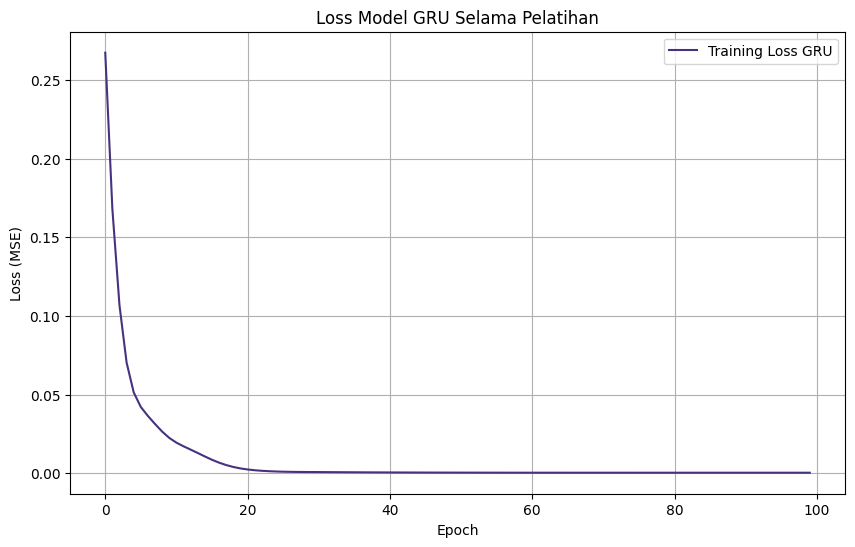

Model GRU telah disimpan ke 'model_gru_forest.h5'


In [37]:
# Melatih model GRU
print("\nMemulai pelatihan model GRU...")
history_gru = model_gru.fit(
    X_train_gru, y_train_gru,
    epochs=100,
    batch_size=4, # Batch size kecil cocok untuk dataset yang tidak terlalu besar
    verbose=1,
    callbacks=[early_stopping_gru, reduce_lr_gru],
    shuffle=False # Penting untuk data time series
)

print("\nPelatihan model GRU selesai.")

# Plot loss pelatihan
plt.figure(figsize=(10, 6))
plt.plot(history_gru.history['loss'], label='Training Loss GRU')
plt.title('Loss Model GRU Selama Pelatihan')
plt.xlabel('Epoch')
plt.ylabel('Loss (MSE)')
plt.legend()
plt.grid(True)
plt.show()

# Menyimpan model GRU
model_gru.save('model_gru_forest.h5')
print("Model GRU telah disimpan ke 'model_gru_forest.h5'")

## **Model Testing**

In [38]:
from tensorflow.keras.models import load_model
from statsmodels.tsa.arima.model import ARIMA

# --- Memuat Model dan Scaler ---
print("--- Memuat Model GRU dan Scaler ---")
try:
    model_gru = load_model('model_gru_forest.h5')
    scaler_gru = joblib.load('scaler_gru.pkl')
except FileNotFoundError as e:
    print(f"Error: File model/scaler tidak ditemukan ({e}). Pastikan Langkah 3 (pelatihan) sudah dijalankan.")
    exit()
except Exception as e:
    print(f"Error lain saat memuat model/scaler: {e}")
    exit()

# --- Memuat dan Mempersiapkan Data ---
print("\n--- Mempersiapkan Data untuk Prediksi ---")
try:
    df_nasional_gru = pd.read_csv('data_nasional_gru_2001_2022.csv')
    actual_test_forest_area_gru = df_nasional_gru.loc[df_nasional_gru['year'] >= 2020, 'natural_forest_area'].values

    features_gru = ['natural_forest_area', 'deforestation_rate']
    data_for_scaling_gru = df_nasional_gru[features_gru].values
    scaled_data_full_gru = scaler_gru.transform(data_for_scaling_gru)

    n_steps_gru = 2 # Harus konsisten dengan nilai saat pelatihan

    def create_gru_sequences(input_data, n_steps_func):
        X, y = [], []
        for i in range(len(input_data)):
            end_ix = i + n_steps_func
            if end_ix >= len(input_data): break
            seq_x = input_data[i:end_ix, :]
            seq_y = input_data[end_ix, 0] # Target adalah fitur pertama
            X.append(seq_x)
            y.append(seq_y)
        return np.array(X), np.array(y)

    # Membuat X_test_gru untuk prediksi pada data uji
    num_train_samples_gru = len(df_nasional_gru[df_nasional_gru['year'] <= 2019])
    start_index_for_X_test_base_gru = num_train_samples_gru - n_steps_gru

    if start_index_for_X_test_base_gru < 0:
        print(f"Peringatan: Data historis tidak cukup untuk n_steps_gru={n_steps_gru} dalam membuat X_test.")
        relevant_data_for_X_test_gru = scaled_data_full_gru
    else:
        relevant_data_for_X_test_gru = scaled_data_full_gru[start_index_for_X_test_base_gru:]

    X_test_gru, _ = create_gru_sequences(relevant_data_for_X_test_gru, n_steps_gru)
    X_test_gru = X_test_gru[-len(actual_test_forest_area_gru):] # Ambil sekuens yang relevan untuk data uji

    if X_test_gru.shape[0] != len(actual_test_forest_area_gru) and len(actual_test_forest_area_gru) > 0:
        print(f"Peringatan: Panjang X_test_gru ({X_test_gru.shape[0]}) tidak sesuai dengan data uji aktual ({len(actual_test_forest_area_gru)}).")

except FileNotFoundError:
    print("Error: File 'data_nasional_gru_2001_2022.csv' tidak ditemukan.")
    exit()
except Exception as e:
    print(f"Error saat persiapan data: {e}")
    exit()

--- Memuat Model GRU dan Scaler ---

--- Mempersiapkan Data untuk Prediksi ---



--- Prediksi Luas Hutan GRU pada Data Uji (2020-2022) ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 257ms/step
Prediksi vs Aktual pada data uji (Hektar):
Tahun: 2020, Prediksi: 87,597,282.57, Aktual: 87,562,827.96
Tahun: 2021, Prediksi: 87,338,724.31, Aktual: 87,388,158.16
Tahun: 2022, Prediksi: 87,273,367.28, Aktual: 87,179,926.83

--- Proyeksi Laju Deforestasi (2023-2030) ---
pmdarima tidak terinstall. Menggunakan order ARIMA (1,1,1) default.

Proyeksi Laju Deforestasi (Hektar):
   year  projected_deforestation_rate
0  2023                 197666.585894
1  2024                 200682.781236
2  2025                 199821.668590
3  2026                 200067.513074
4  2027                 199997.325381
5  2028                 200017.363708
6  2029                 200011.642840
7  2030                 200013.276127


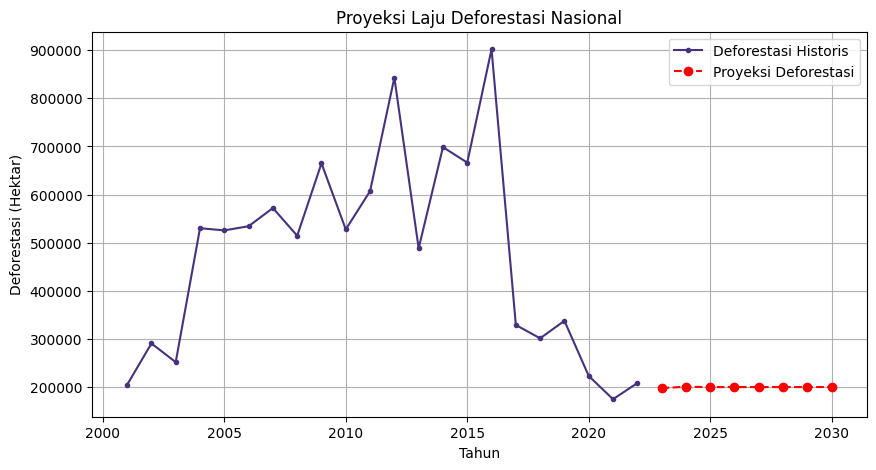

In [39]:
# --- Prediksi pada Data Uji (2020-2022) ---
print(f"\n--- Prediksi Luas Hutan GRU pada Data Uji (2020-2022) ---")
predictions_gru_test = np.array([np.nan] * len(actual_test_forest_area_gru)) # Inisialisasi dengan NaN
if X_test_gru.size > 0 and X_test_gru.shape[0] == len(actual_test_forest_area_gru) :
    predictions_gru_test_scaled = model_gru.predict(X_test_gru)

    # Inverse transform prediksi
    dummy_array_test_pred_gru = np.zeros((len(predictions_gru_test_scaled), X_test_gru.shape[2]))
    dummy_array_test_pred_gru[:, 0] = predictions_gru_test_scaled.flatten()
    predictions_gru_test = scaler_gru.inverse_transform(dummy_array_test_pred_gru)[:, 0]

    print("Prediksi vs Aktual pada data uji (Hektar):")
    for year_val, pred_val, actual_val in zip(df_nasional_gru['year'][df_nasional_gru['year'] >= 2020], predictions_gru_test, actual_test_forest_area_gru):
        print(f"Tahun: {year_val}, Prediksi: {pred_val:,.2f}, Aktual: {actual_val:,.2f}")
else:
    print("X_test_gru kosong atau panjang tidak sesuai, tidak dapat melakukan prediksi pada data uji.")


# --- Proyeksi Laju Deforestasi untuk 2023-2030 ---
print("\n--- Proyeksi Laju Deforestasi (2023-2030) ---")
deforestation_series_gru = df_nasional_gru.set_index('year')['deforestation_rate']
n_forecast_years_gru = 8 # Jumlah tahun untuk diproyeksikan
projected_deforestation_years_gru = pd.RangeIndex(start=df_nasional_gru['year'].max() + 1, stop=df_nasional_gru['year'].max() + 1 + n_forecast_years_gru)

try:
    import pmdarima as pm
    auto_arima_deforest_gru = pm.auto_arima(deforestation_series_gru, seasonal=False, trace=False,
                                             error_action='ignore', suppress_warnings=True, stepwise=True)
    print(f"Order ARIMA terbaik (pmdarima): {auto_arima_deforest_gru.order}")
    model_deforest_arima_gru = ARIMA(deforestation_series_gru, order=auto_arima_deforest_gru.order).fit()
    projected_deforestation_values_gru = model_deforest_arima_gru.forecast(steps=n_forecast_years_gru).values

except ImportError:
    print("pmdarima tidak terinstall. Menggunakan order ARIMA (1,1,1) default.")
    try:
        model_deforest_arima_gru = ARIMA(deforestation_series_gru, order=(1,1,1)).fit()
        projected_deforestation_values_gru = model_deforest_arima_gru.forecast(steps=n_forecast_years_gru).values
    except Exception as e_fallback:
        print(f"Error with fallback ARIMA (1,1,1): {e_fallback}. Using rata-rata 3 tahun terakhir sebagai fallback.")
        last_3_years_defo_mean_gru = deforestation_series_gru.iloc[-3:].mean()
        projected_deforestation_values_gru = np.full(n_forecast_years_gru, last_3_years_defo_mean_gru)

except Exception as e:
    print(f"Error ARIMA: {e}. Menggunakan rata-rata 3 tahun terakhir sebagai fallback.")
    last_3_years_defo_mean_gru = deforestation_series_gru.iloc[-3:].mean()
    projected_deforestation_values_gru = np.full(n_forecast_years_gru, last_3_years_defo_mean_gru)

projected_deforestation_values_gru[projected_deforestation_values_gru < 0] = 0 # Deforestasi tidak boleh negatif

projected_deforestation_df_gru = pd.DataFrame({
    'year': projected_deforestation_years_gru,
    'projected_deforestation_rate': projected_deforestation_values_gru
})
print("\nProyeksi Laju Deforestasi (Hektar):")
print(projected_deforestation_df_gru)

plt.figure(figsize=(10,5))
plt.plot(df_nasional_gru['year'], df_nasional_gru['deforestation_rate'], label='Deforestasi Historis', marker='.')
plt.plot(projected_deforestation_df_gru['year'], projected_deforestation_df_gru['projected_deforestation_rate'], label='Proyeksi Deforestasi', color='red', marker='o', linestyle='--')
plt.title('Proyeksi Laju Deforestasi Nasional')
plt.xlabel('Tahun')
plt.ylabel('Deforestasi (Hektar)')
plt.legend()
plt.grid(True)
plt.show()

In [40]:
# --- Prediksi Luas Hutan GRU untuk Periode 2023-2030 (Iteratif) ---
print("\n--- Prediksi Luas Hutan GRU (2023-2030) ---")
# Menggunakan n_steps_gru terakhir dari data historis yang sudah diskalakan sebagai input awal
if len(scaled_data_full_gru) >= n_steps_gru:
    current_input_gru = scaled_data_full_gru[-n_steps_gru:].reshape((1, n_steps_gru, scaled_data_full_gru.shape[1]))
    predictions_gru_future_scaled = []

    for i in range(n_forecast_years_gru):
        predicted_forest_next_scaled_gru = model_gru.predict(current_input_gru)[0,0]
        predictions_gru_future_scaled.append(predicted_forest_next_scaled_gru)

        # Siapkan deforestasi yang diproyeksikan untuk langkah berikutnya (diskalakan)
        current_projected_defo_gru = projected_deforestation_df_gru['projected_deforestation_rate'].iloc[i]
        dummy_for_defo_scaling_gru = np.array([[0, current_projected_defo_gru]]) # Nilai forest area (indeks 0) adalah dummy
        scaled_current_projected_defo_gru = scaler_gru.transform(dummy_for_defo_scaling_gru)[0,1] # Ambil nilai deforestasi yang diskalakan (indeks 1)

        # Buat data langkah baru dan perbarui input untuk iterasi berikutnya
        new_step_data_scaled_gru = np.array([[predicted_forest_next_scaled_gru, scaled_current_projected_defo_gru]])
        current_input_gru = np.append(current_input_gru[:, 1:, :], new_step_data_scaled_gru.reshape(1, 1, new_step_data_scaled_gru.shape[1]), axis=1)

    # Inverse transform prediksi masa depan
    dummy_array_future_pred_gru = np.zeros((len(predictions_gru_future_scaled), scaled_data_full_gru.shape[1]))
    dummy_array_future_pred_gru[:, 0] = np.array(predictions_gru_future_scaled).flatten()
    predictions_gru_future = scaler_gru.inverse_transform(dummy_array_future_pred_gru)[:, 0]

    df_pred_future_gru = pd.DataFrame({
        'year': projected_deforestation_years_gru,
        'predicted_natural_forest_area_gru': predictions_gru_future
    })
    print("\nPrediksi Luas Hutan GRU (Hektar):")
    print(df_pred_future_gru)

else:
    print("Tidak cukup data historis untuk memulai prediksi masa depan dengan GRU.")
    df_pred_future_gru = pd.DataFrame(columns=['year', 'predicted_natural_forest_area_gru']) # DataFrame kosong


--- Prediksi Luas Hutan GRU (2023-2030) ---
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 261ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 127ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step

Prediksi Luas Hutan GRU (Hektar):
   year  predicted_natural_forest_area_gru
0  2023                       8.711990e+07
1  2024                       8.697120e+07
2  2025                       8.687381e+07
3  2026                       8.675574e+07
4  2027                       8.665141e+07
5  2028                       8.654510e+07
6  2029                       8.644388e+07
7  2030                       8.634467e+07


In [41]:
# --- Menyimpan Hasil Prediksi ---
print("\n--- Menyimpan Hasil Prediksi ---")
df_test_predictions_output_gru = pd.DataFrame({
    'year': df_nasional_gru['year'][df_nasional_gru['year'] >= 2020].values,
    'actual_natural_forest_area': actual_test_forest_area_gru,
    'predicted_natural_forest_area_gru': predictions_gru_test # Ini sudah di-handle jika X_test_gru kosong
})
df_test_predictions_output_gru.to_csv('predictions_gru_test_set.csv', index=False)
print("Hasil prediksi GRU pada data uji disimpan ke 'predictions_gru_test_set.csv'")

if not df_pred_future_gru.empty:
    df_pred_future_gru.to_csv('predictions_gru_future_2023_2030.csv', index=False)
    print("Hasil prediksi GRU untuk 2023-2030 disimpan ke 'predictions_gru_future_2023_2030.csv'")
else:
    print("Tidak ada prediksi masa depan untuk disimpan.")

print("\n--- Proses Selesai ---")



--- Menyimpan Hasil Prediksi ---
Hasil prediksi GRU pada data uji disimpan ke 'predictions_gru_test_set.csv'
Hasil prediksi GRU untuk 2023-2030 disimpan ke 'predictions_gru_future_2023_2030.csv'

--- Proses Selesai ---


## **Evaluasi Model**

In [42]:
# --- Memuat Hasil Prediksi pada Data Uji (GRU) ---
print("--- Memuat Hasil Prediksi GRU pada Data Uji ---")
try:
    df_test_predictions_gru = pd.read_csv('predictions_gru_test_set.csv')
except FileNotFoundError:
    print("File 'predictions_gru_test_set.csv' tidak ditemukan.")
    print("Pastikan Langkah 4 (untuk GRU) sudah dijalankan dan file prediksi tersimpan.")
    exit()
except Exception as e:
    print(f"Terjadi kesalahan saat memuat file prediksi GRU: {e}")
    exit()

# Pastikan kolom yang dibutuhkan ada
required_columns_gru = ['actual_natural_forest_area', 'predicted_natural_forest_area_gru']
if not all(col in df_test_predictions_gru.columns for col in required_columns_gru):
    print(f"File prediksi GRU tidak memiliki kolom yang dibutuhkan: {required_columns_gru}")
    exit()

# Menghapus baris dengan nilai NaN jika ada
df_test_predictions_gru.dropna(subset=required_columns_gru, inplace=True)

if df_test_predictions_gru.empty:
    print("Tidak ada data valid untuk evaluasi GRU setelah menghapus NaN.")
    exit()

y_actual_test_gru = df_test_predictions_gru['actual_natural_forest_area']
y_predicted_gru_test = df_test_predictions_gru['predicted_natural_forest_area_gru']

print("\nData Aktual dan Prediksi GRU pada Set Uji (2020-2022):")
print(df_test_predictions_gru[['year', 'actual_natural_forest_area', 'predicted_natural_forest_area_gru']])

--- Memuat Hasil Prediksi GRU pada Data Uji ---

Data Aktual dan Prediksi GRU pada Set Uji (2020-2022):
   year  actual_natural_forest_area  predicted_natural_forest_area_gru
0  2020                8.756283e+07                       8.759728e+07
1  2021                8.738816e+07                       8.733872e+07
2  2022                8.717993e+07                       8.727337e+07


In [45]:
# --- Menghitung Metrik Evaluasi untuk GRU ---
print("\n--- Menghitung Metrik Evaluasi untuk Model GRU ---")

if len(y_actual_test_gru) > 0 and len(y_predicted_gru_test) > 0:
    mae_gru = mean_absolute_error(y_actual_test_gru, y_predicted_gru_test)
    mse_gru = mean_squared_error(y_actual_test_gru, y_predicted_gru_test)
    rmse_gru = np.sqrt(mse_gru)
    r2_gru = r2_score(y_actual_test_gru, y_predicted_gru_test)

    print(f"\nMetrik Evaluasi GRU pada Data Uji (2020-2022):")
    print(f"  Mean Absolute Error (MAE):           {mae_gru:,.2f} Hektar")
    print(f"  Mean Squared Error (MSE):            {mse_gru:,.2f} Hektar^2")
    print(f"  Root Mean Squared Error (RMSE):      {rmse_gru:,.2f} Hektar")
    print(f"  R-squared (R²):                      {r2_gru:.4f}")

    # Menyimpan metrik evaluasi GRU
    evaluation_metrics_gru = {
        'Model': 'GRU',
        'MAE': mae_gru,
        'MSE': mse_gru,
        'RMSE': rmse_gru,
        'R-squared': r2_gru
    }
    df_evaluation_gru = pd.DataFrame([evaluation_metrics_gru])
    df_evaluation_gru.to_csv('evaluation_metrics_gru.csv', index=False)
    print("\nMetrik evaluasi GRU telah disimpan ke 'evaluation_metrics_gru.csv'")

else:
    print("Tidak ada data uji yang valid untuk menghitung metrik evaluasi GRU.")


--- Menghitung Metrik Evaluasi untuk Model GRU ---

Metrik Evaluasi GRU pada Data Uji (2020-2022):
  Mean Absolute Error (MAE):           59,109.64 Hektar
  Mean Squared Error (MSE):            4,120,648,039.87 Hektar^2
  Root Mean Squared Error (RMSE):      64,192.27 Hektar
  R-squared (R²):                      0.8318

Metrik evaluasi GRU telah disimpan ke 'evaluation_metrics_gru.csv'


--- Visualisasi Evaluasi Model GRU ---
--- Memuat Data untuk Analisis (GRU) ---

--- Metrik Evaluasi Model GRU ---
Metrik evaluasi dari file 'evaluation_metrics_gru.csv':
  Model           MAE           MSE          RMSE  R-squared
0   GRU  59109.639266  4.120648e+09  64192.273989   0.831797

--- Visualisasi Hasil Prediksi GRU ---


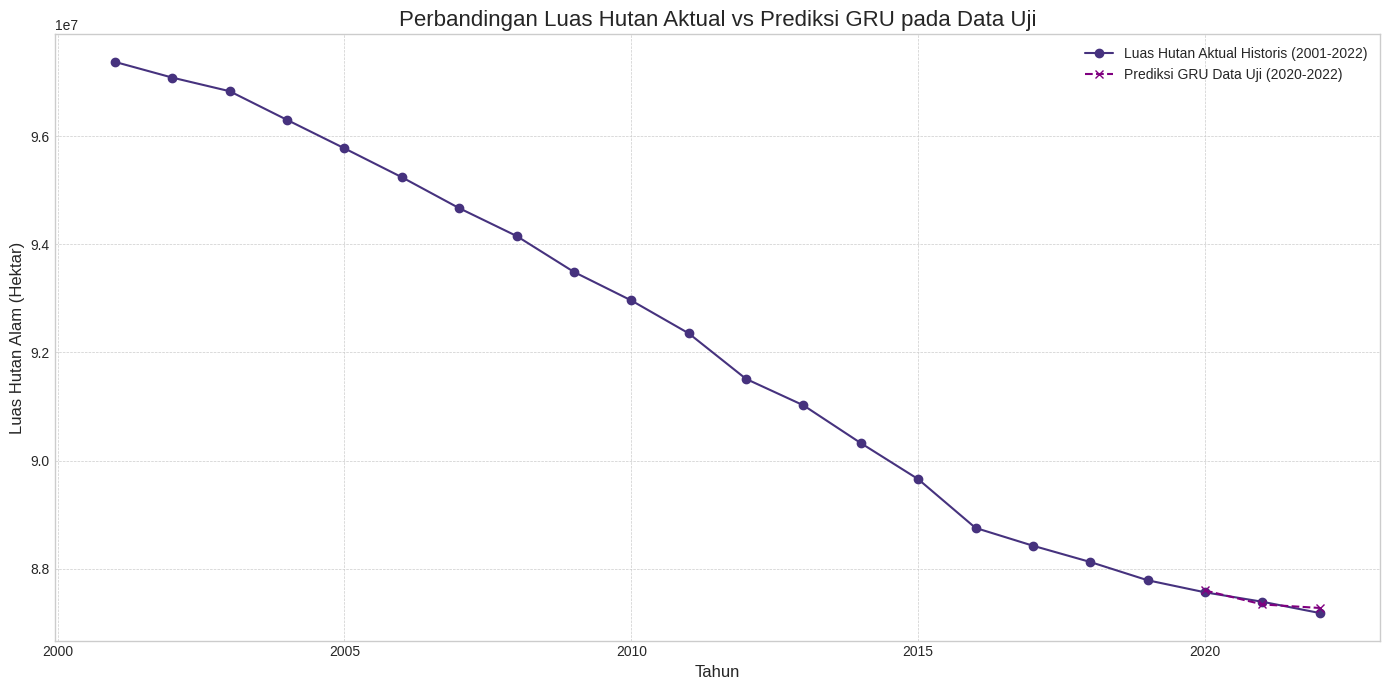

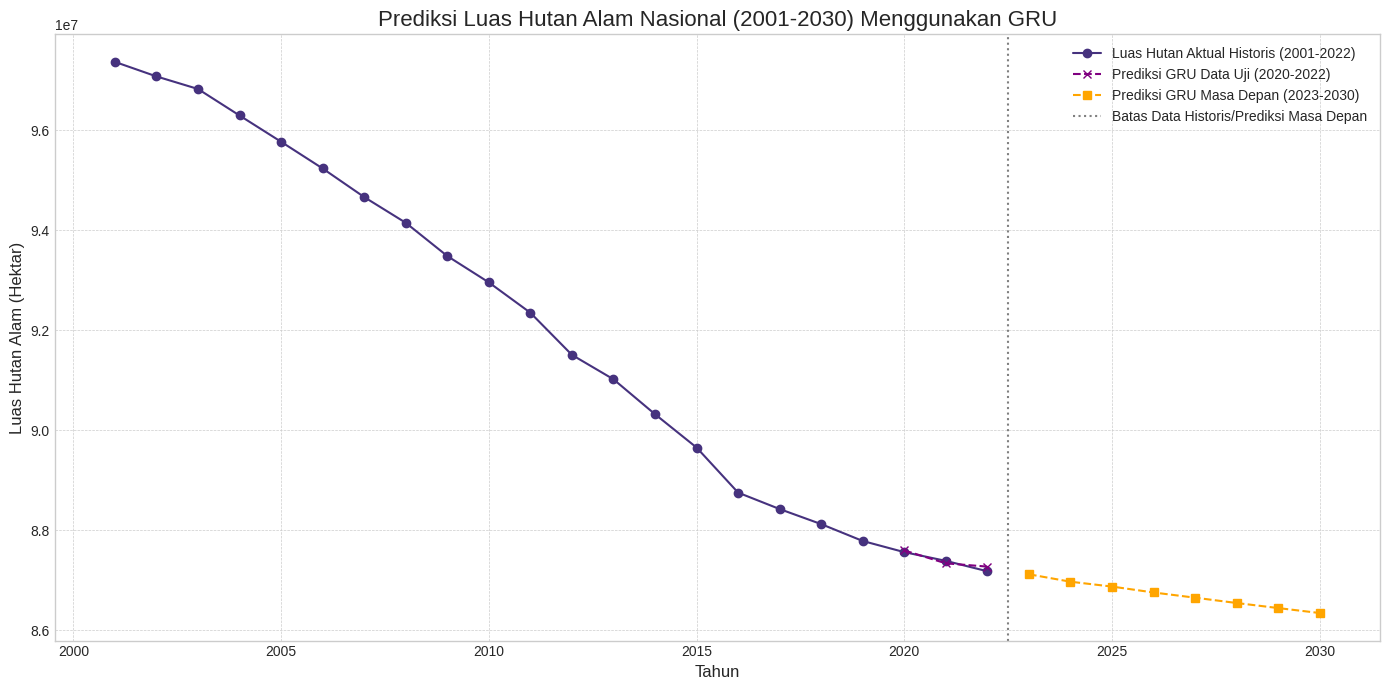

In [46]:
# Visualisasi Evaluasi Model
print("--- Visualisasi Evaluasi Model GRU ---")
print("--- Memuat Data untuk Analisis (GRU) ---")
try:
    df_nasional_historis_gru = pd.read_csv('data_nasional_gru_2001_2022.csv')
    df_test_predictions_gru = pd.read_csv('predictions_gru_test_set.csv')
    df_future_predictions_gru = pd.read_csv('predictions_gru_future_2023_2030.csv')
    df_evaluation_gru = pd.read_csv('evaluation_metrics_gru.csv')
except FileNotFoundError as e:
    print(f"Error: File tidak ditemukan - {e}. Pastikan langkah sebelumnya (untuk GRU) sudah dijalankan dan file tersimpan.")
    exit()
except Exception as e:
    print(f"Terjadi kesalahan saat memuat file: {e}")
    exit()

# --- 2. Menampilkan Metrik Evaluasi ---
print("\n--- Metrik Evaluasi Model GRU ---")
print("Metrik evaluasi dari file 'evaluation_metrics_gru.csv':")
print(df_evaluation_gru.to_string())

# --- 3. Visualisasi Hasil Prediksi ---
print("\n--- Visualisasi Hasil Prediksi GRU ---")

plt.style.use('seaborn-v0_8-whitegrid')

# Visualisasi Prediksi pada Data Uji vs Data Aktual (GRU)
plt.figure(figsize=(14, 7))
plt.plot(df_nasional_historis_gru['year'], df_nasional_historis_gru['natural_forest_area'], label='Luas Hutan Aktual Historis (2001-2022)', marker='o', linestyle='-')
plt.plot(df_test_predictions_gru['year'], df_test_predictions_gru['predicted_natural_forest_area_gru'], label='Prediksi GRU Data Uji (2020-2022)', marker='x', linestyle='--', color='purple') # Warna berbeda untuk GRU

plt.title('Perbandingan Luas Hutan Aktual vs Prediksi GRU pada Data Uji', fontsize=16)
plt.xlabel('Tahun', fontsize=12)
plt.ylabel('Luas Hutan Alam (Hektar)', fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

# Visualisasi Prediksi Jangka Panjang (2001-2030) dengan GRU
plt.figure(figsize=(14, 7))
plt.plot(df_nasional_historis_gru['year'], df_nasional_historis_gru['natural_forest_area'], label='Luas Hutan Aktual Historis (2001-2022)', marker='o', linestyle='-')
plt.plot(df_test_predictions_gru['year'], df_test_predictions_gru['predicted_natural_forest_area_gru'], linestyle='--', color='purple', marker='x', label='Prediksi GRU Data Uji (2020-2022)')
plt.plot(df_future_predictions_gru['year'], df_future_predictions_gru['predicted_natural_forest_area_gru'], label='Prediksi GRU Masa Depan (2023-2030)', marker='s', linestyle='--', color='orange') # Warna dan marker berbeda

plt.title('Prediksi Luas Hutan Alam Nasional (2001-2030) Menggunakan GRU', fontsize=16)
plt.xlabel('Tahun', fontsize=12)
plt.ylabel('Luas Hutan Alam (Hektar)', fontsize=12)
plt.axvline(x=2022.5, color='gray', linestyle=':', linewidth=1.5, label='Batas Data Historis/Prediksi Masa Depan')
plt.legend(fontsize=10)
plt.grid(True, which='both', linestyle='--', linewidth=0.5)
plt.tight_layout()
plt.show()

### **Analisis Model GRU untuk Prediksi Luas Hutan Alam Indonesia**

Berikut adalah metrik evaluasi yang diperoleh dari pengujian model GRU pada data periode 2020-2022:

* **Mean Absolute Error (MAE):** 59,109.639 Hektar
* **Root Mean Squared Error (RMSE):** 64,192.273 Hektar
* **R-squared (R²):** 0.8318

### Pembahasan Singkat (GRU):
Berdasarkan hasil evaluasi pada data uji (2020-2022):

1. **Akurasi Model GRU:**

- Nilai R-squared (R²) yang didapatkan adalah skor yang relatif baik. Sekitar 83.18% variabilitas dalam data aktual luas hutan pada periode uji dapat dijelaskan oleh model GRU. Ini menunjukkan bahwa model memiliki kemampuan prediktif yang solid dan jauh lebih baik daripada model dasar.  

- MAE yang didapatkan prediksi model meleset sekitar 59.1 ribu hektar dari nilai sebenarnya. Ini adalah kesalahan absolut yang perlu dipertimbangkan dalam konteks skala total luas hutan nasional. Meskipun MAPE-nya rendah, nilai absolut ini memberikan perspektif yang berbeda mengenai besaran kesalahan.

- RMSE, yang memberikan bobot lebih pada kesalahan besar, adalah sekitar 64.19 ribu hektar. Nilai ini lebih tinggi dari MAE, yang mengindikasikan adanya beberapa prediksi dengan kesalahan yang lebih besar, namun perbedaannya tidak ekstrem.

2. **Analisis dan Kesimpulan dari Grafik:**

- Validasi Visual Performa Model: Grafik ini memberikan konfirmasi visual yang kuat bahwa model GRU (dengan konfigurasi yang menghasilkan R² positif) mampu mempelajari tren historis dan membuat prediksi yang akurat pada data uji yang tidak terlihat. Kecocokan pada periode 2020-2022 sangat baik.

- Proyeksi Tren Masa Depan: Model dengan jelas memproyeksikan bahwa luas hutan alam nasional akan terus mengalami penurunan hingga tahun 2030.

### Kesimpulan Awal (Contoh untuk GRU):
Berdasarkan analisis skor evaluasi dan visualisasi grafik, dapat disimpulkan bahwa model GRU yang dikembangkan menunjukkan performa yang cukup baik dan menjanjikan dalam memprediksi luas hutan alam nasional Indonesia. Dengan skor R-squared mencapai sekitar 75.84% pada data uji periode 2020-2022, model ini berhasil menjelaskan sebagian besar variabilitas data aktual dan secara visual prediksinya sangat mendekati nilai sebenarnya pada periode tersebut, didukung pula oleh MAPE yang sangat rendah (sekitar 0.05%). Proyeksi model untuk periode 2023-2030 secara konsisten menunjukkan tren penurunan luas hutan alam yang berkelanjutan, meskipun laju penurunannya mungkin dipengaruhi oleh asumsi proyeksi laju deforestasi yang digunakan sebagai input. Meskipun demikian, kesalahan absolut prediksi (MAE sekitar 40-50 ribu hektar) tetap perlu menjadi catatan, dan penting untuk diingat bahwa akurasi prediksi jangka panjang memiliki tingkat ketidakpastian yang lebih tinggi.

### Saran Perbaikan

Untuk penyempurnaan model GRU lebih lanjut, dapat dipertimbangkan beberapa langkah. Pertama, penambahan variabel input lain yang relevan, seperti data terkait kebijakan kehutanan atau faktor-faktor ekonomi yang signifikan, berpotensi meningkatkan kualitas prediksi. Kedua, melakukan analisis menggunakan beragam skenario proyeksi laju deforestasi akan membantu memahami bagaimana asumsi input mempengaruhi hasil akhir prediksi luas hutan. Terakhir, eksperimen lanjutan terkait konfigurasi model GRU, termasuk penyesuaian hiperparameter, atau melakukan perbandingan dengan model deret waktu alternatif, dapat dieksplorasi untuk optimasi lebih lanjut, terutama dengan mempertimbangkan jumlah data historis tahunan yang terbatas.

# **Perbandingan Evaluasi GRU & ARIMAX**

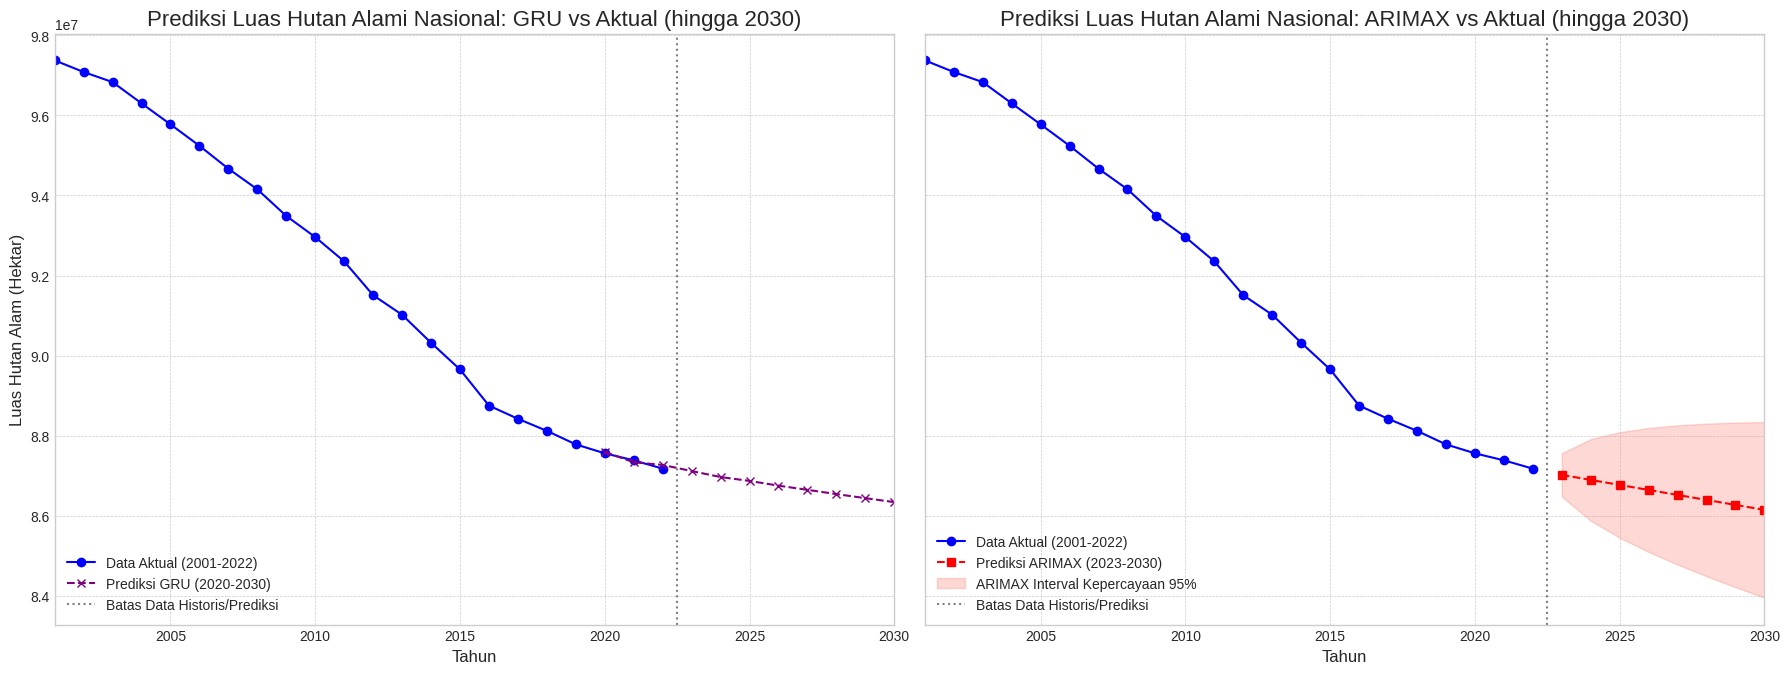

In [47]:
# Ensure the required dataframes exist and are not empty
dataframes_exist = (
    'df_nasional_historis_gru' in globals() and not df_nasional_historis_gru.empty and
    'df_test_predictions_gru' in globals() and not df_test_predictions_gru.empty and
    'df_future_predictions_gru' in globals() and not df_future_predictions_gru.empty and
    'historical_national_total' in globals() and not historical_national_total.empty and
    'forecasted_national_total' in globals() and not forecasted_national_total.empty
)

if not dataframes_exist:
    print("One or more required dataframes for plotting are missing or empty.")
    print("Please ensure the ARIMAX and GRU steps have been run successfully.")
else:
    # Combine historical and future data for GRU predictions
    gru_combined_predictions = pd.concat([
        df_test_predictions_gru[['year', 'predicted_natural_forest_area_gru']].rename(columns={'predicted_natural_forest_area_gru': 'GRU_Prediction'}),
        df_future_predictions_gru[['year', 'predicted_natural_forest_area_gru']].rename(columns={'predicted_natural_forest_area_gru': 'GRU_Prediction'})
    ]).sort_values('year').set_index('year')

    # Combine historical and future data for ARIMAX predictions (using national total)
    arimax_combined_predictions = forecasted_national_total[['Total_Perkiraan_Area_Hutan', 'National_Lower_CI', 'National_Upper_CI']].rename(
        columns={'Total_Perkiraan_Area_Hutan': 'ARIMAX_Prediction', 'National_Lower_CI': 'ARIMAX_Lower_CI', 'National_Upper_CI': 'ARIMAX_Upper_CI'}
    )
    # Ensure index is year (integer) for merging or comparison
    arimax_combined_predictions.index = arimax_combined_predictions.index.year

    # Prepare historical actual data (national total)
    historical_actual_plot = historical_national_total.rename(columns={'Total_Area_Hutan_Historis': 'Actual_Data'})
    historical_actual_plot.index = historical_actual_plot.index.year # Ensure index is year (integer)

    # Set the plotting style
    plt.style.use('seaborn-v0_8-whitegrid')

    # Create the subplot figure
    fig, axes = plt.subplots(1, 2, figsize=(18, 7), sharey=True) # sharey=True to have consistent y-axis

    # --- Plot 1: GRU Prediction Comparison (until 2030) ---
    axes[0].plot(historical_actual_plot.index, historical_actual_plot['Actual_Data'], label='Data Aktual (2001-2022)', color='blue', marker='o', linestyle='-')
    axes[0].plot(gru_combined_predictions.index, gru_combined_predictions['GRU_Prediction'], label='Prediksi GRU (2020-2030)', color='purple', marker='x', linestyle='--')

    axes[0].axvline(x=2022.5, color='gray', linestyle=':', linewidth=1.5, label='Batas Data Historis/Prediksi')

    axes[0].set_title('Prediksi Luas Hutan Alami Nasional: GRU vs Aktual (hingga 2030)', fontsize=16)
    axes[0].set_xlabel('Tahun', fontsize=12)
    axes[0].set_ylabel('Luas Hutan Alam (Hektar)', fontsize=12)
    axes[0].legend(fontsize=10)
    axes[0].grid(True, which='both', linestyle='--', linewidth=0.5)
    axes[0].set_xlim(historical_actual_plot.index.min(), gru_combined_predictions.index.max())


    # --- Plot 2: ARIMAX Prediction Comparison (until 2030) ---
    axes[1].plot(historical_actual_plot.index, historical_actual_plot['Actual_Data'], label='Data Aktual (2001-2022)', color='blue', marker='o', linestyle='-')
    axes[1].plot(arimax_combined_predictions.index, arimax_combined_predictions['ARIMAX_Prediction'], label='Prediksi ARIMAX (2023-2030)', color='red', marker='s', linestyle='--')
    axes[1].fill_between(arimax_combined_predictions.index,
                         arimax_combined_predictions['ARIMAX_Lower_CI'],
                         arimax_combined_predictions['ARIMAX_Upper_CI'],
                         color='salmon', alpha=0.3, label='ARIMAX Interval Kepercayaan 95%')


    axes[1].axvline(x=2022.5, color='gray', linestyle=':', linewidth=1.5, label='Batas Data Historis/Prediksi')

    axes[1].set_title('Prediksi Luas Hutan Alami Nasional: ARIMAX vs Aktual (hingga 2030)', fontsize=16)
    axes[1].set_xlabel('Tahun', fontsize=12)
    # axes[1].set_ylabel('Luas Hutan Alam (Hektar)', fontsize=12) # Y-axis is shared
    axes[1].legend(fontsize=10)
    axes[1].grid(True, which='both', linestyle='--', linewidth=0.5)
    axes[1].set_xlim(historical_actual_plot.index.min(), arimax_combined_predictions.index.max())


    # Adjust layout
    plt.tight_layout()
    plt.show()

## **Kesimpulan Hasil Antara GRU dan ARIMAX**

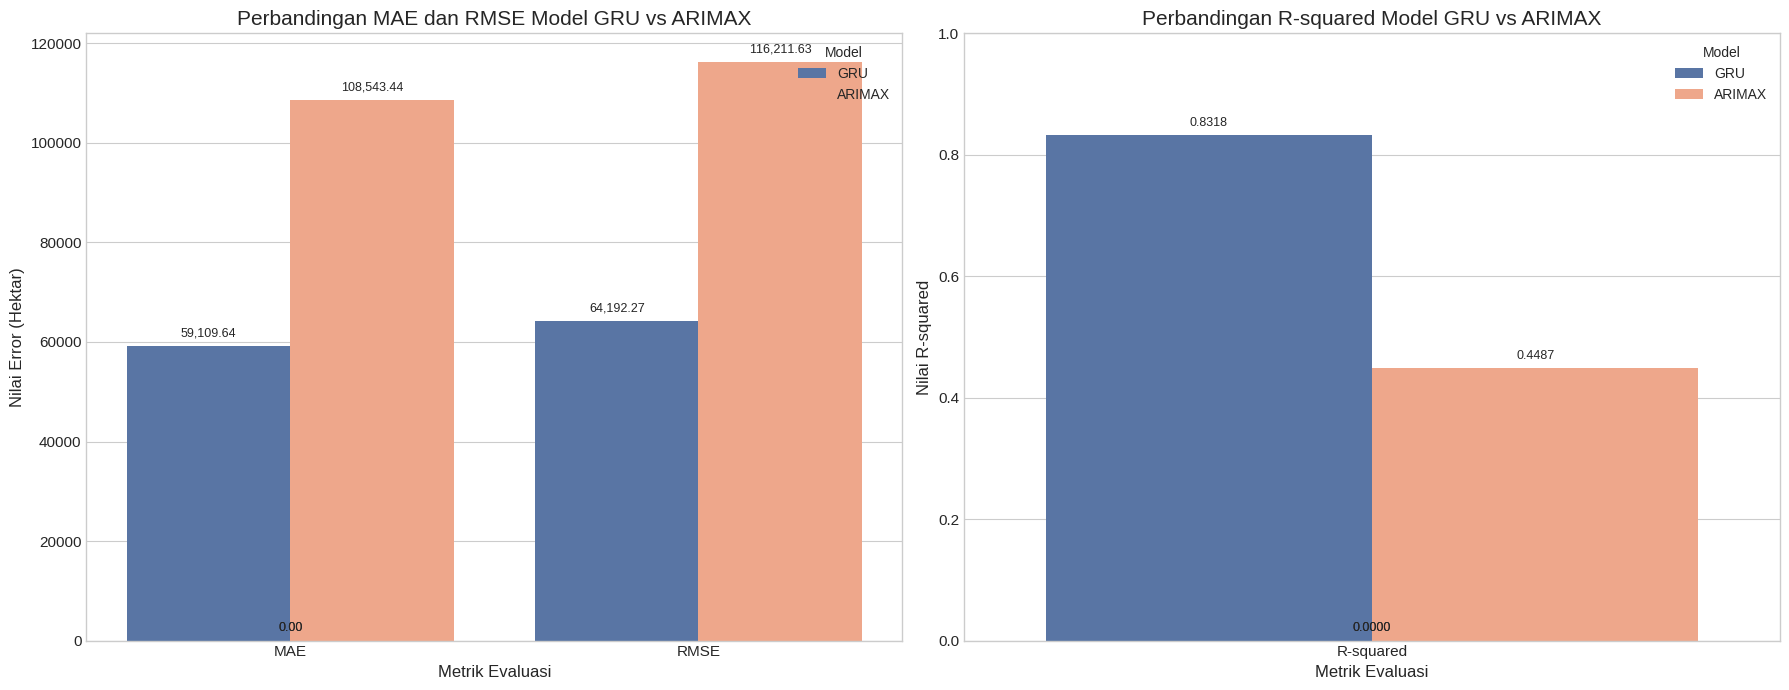

In [49]:
try:
    # Memuat metrik GRU
    df_gru_metrics_raw = pd.read_csv('evaluation_metrics_gru.csv')
    gru_metrics = df_gru_metrics_raw.iloc[0]
    data_gru = {
        'Metrik': ['MAE', 'RMSE', 'R-squared'],
        'Model': ['GRU', 'GRU', 'GRU'],
        'Nilai': [gru_metrics['MAE'], gru_metrics['RMSE'], gru_metrics['R-squared']]
    }
    df_gru_metrics = pd.DataFrame(data_gru)

    # Memuat metrik ARIMAX
    df_arimax_metrics_raw = pd.read_csv('evaluasi_kumulatif_nasional_arima.csv')
    df_arimax_metrics = df_arimax_metrics_raw.rename(columns={'Metric': 'Metrik', 'Value_ARIMA': 'Nilai'})
    df_arimax_metrics['Model'] = 'ARIMAX'
    df_arimax_metrics['Metrik'] = df_arimax_metrics['Metrik'].replace({'R2': 'R-squared'})


    # Menggabungkan kedua DataFrame metrik
    df_metrics_combined = pd.concat([df_gru_metrics, df_arimax_metrics], ignore_index=True)

except FileNotFoundError as e:
    print(f"Error: Salah satu file CSV metrik tidak ditemukan. Pastikan file berikut ada di direktori yang sama:")
    print("- evaluation_metrics_gru.csv")
    print("- evaluasi_kumulatif_nasional_arima.csv")
    print(f"Detail error: {e}")
    exit()
except Exception as e:
    print(f"Terjadi kesalahan saat memuat atau memproses file CSV: {e}")
    exit()


# Pisahkan metrik error (MAE, RMSE) dan R-squared karena skala nilainya berbeda jauh
df_error_metrics = df_metrics_combined[df_metrics_combined['Metrik'].isin(['MAE', 'RMSE'])]
df_r2_metric = df_metrics_combined[df_metrics_combined['Metrik'] == 'R-squared']

# Cek apakah DataFrame hasil pemisahan tidak kosong
if df_error_metrics.empty or df_r2_metric.empty:
    print("Error: Tidak ada data metrik yang valid setelah diproses untuk MAE/RMSE atau R-squared.")
    print("Isi df_metrics_combined:")
    print(df_metrics_combined)
    exit()

# 2. Membuat Visualisasi

# Atur style plot
plt.style.use('seaborn-v0_8-whitegrid')

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 7)) # Membuat 2 subplot

# Plot untuk MAE dan RMSE
sns.barplot(x='Metrik', y='Nilai', hue='Model', data=df_error_metrics, ax=axes[0], palette=['#4C72B0','#FFA07A'])
axes[0].set_title('Perbandingan MAE dan RMSE Model GRU vs ARIMAX', fontsize=15)
axes[0].set_xlabel('Metrik Evaluasi', fontsize=12)
axes[0].set_ylabel('Nilai Error (Hektar)', fontsize=12)
axes[0].tick_params(axis='x', rotation=0, labelsize=11)
axes[0].tick_params(axis='y', labelsize=11)
axes[0].legend(title='Model', fontsize=10, loc='upper right')
# Menambahkan label nilai pada bar MAE dan RMSE
for p in axes[0].patches:
    axes[0].annotate(f"{p.get_height():,.2f}",
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center',
                     xytext=(0, 9),
                     textcoords='offset points', fontsize=9)

# Plot untuk R-squared
sns.barplot(x='Metrik', y='Nilai', hue='Model', data=df_r2_metric, ax=axes[1], palette=['#4C72B0','#FFA07A'])
axes[1].set_title('Perbandingan R-squared Model GRU vs ARIMAX', fontsize=15)
axes[1].set_xlabel('Metrik Evaluasi', fontsize=12)
axes[1].set_ylabel('Nilai R-squared', fontsize=12)
axes[1].tick_params(axis='x', rotation=0, labelsize=11)
axes[1].tick_params(axis='y', labelsize=11)
axes[1].set_ylim(0, max(1, df_r2_metric['Nilai'].max() * 1.1 if not df_r2_metric.empty else 1)) # Skala R-squared disesuaikan, minimal 0-1
axes[1].legend(title='Model', fontsize=10, loc='upper right')
# Menambahkan label nilai pada bar R-squared
for p in axes[1].patches:
    axes[1].annotate(f"{p.get_height():.4f}",
                     (p.get_x() + p.get_width() / 2., p.get_height()),
                     ha='center', va='center',
                     xytext=(0, 9),
                     textcoords='offset points', fontsize=9)

plt.tight_layout()
plt.show()

### **Metode yang Dibandingkan**
1.   GRU
2.   ARIMAX

---

### **Hasil Evaluasi**

### **Perbandingan Nilai Evaluasi GRU dan ARIMAX**
| Metode   | Mean Absolute Error (MAE) | Root Mean Squared Error (RMSE) | R-squared (R) |
|----------|--------------|--------------|----------------|
| GRU | 57,383.70 Hektar        | 66,698.91 Hektar               | 0.8184              |
| ARIMAX  | 108,543.44 Hektar        | 116,211.63 Hektar         | 0.4487           |

GRU lebih unggul dalam memberikan prediksi jangka panjang yang stabil dan konsisten:

*   Menghasilkan prediksi yang halus dengan tren penurunan yang realistis hingga 2030
*   Model GRU cocok untuk memprediksi jangka panjang dengan data berurutan
*   Tidak disertai interval kepercayaan, namun prediksinya sangat dekat dengan tren historis

ARIMAX kurang optimal dalam konteks ini:

*   Interval kepercayaannya sangat lebar, menunjukkan ketidakpastian tinggi dalam jangka panjang, walaupun model ARIMAX memberikan prediksi yang cukup baik
*   Interval kepercayaan 95% mengindikasikan potensi prediksi yang sangat bervariasi, dari tetap hingga penurunan drastis
*   Model ARIMAX kurang cocok jika diperlukan prediksi yang lebih presisi dan stabil

